# OAM 3He Experiment:
***

## Constants and functions

In [8]:
import numpy as np
import sympy as sym
import scipy as sc
import matplotlib.pyplot as plt
from matplotlib import cm
import mcstasscript as ms
import scienceplots
import time, math, os, csv
from scipy.optimize import curve_fit
from scipy.signal import hilbert,convolve,find_peaks,savgol_filter
from scipy.fft import fft,fftfreq,ifft
from scipy.integrate import quad,simpson
from scipy.interpolate import CubicSpline
from matplotlib.animation import FuncAnimation, PillowWriter
from itertools import islice,chain

plt.style.use(['science', 'notebook', 'grid', 'default', 'bright'])
plot_height = 8
plot_width = plot_height*1.618

#np.set_printoptions(suppress=False,precision=5)
np.set_printoptions(suppress=True)

SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 15,20,25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size (glitch in matplotlib?)
#plt.rcParams.update({'axes.grid':True})

plt.rc('text', usetex=False)
if False: #Additions to latex preamble for matplotlib:
    plt.rc('text', usetex=True)
    plt.rc('text.latex', preamble=r'\usepackage{amsmath,amsthm,amssymb,amsfonts,braket,siunitx}')
    plt.rcParams["font.family"] = "Computer Modern Roman"
    sym.init_printing()

gN = -1.832471e8    #gyromagnetic ratio of neutron (rad/T/m^2)
mN = 1.674927e-27    #mass of neutron (kg)
hbar = 1.054571e-34    #plancks constant (kg m^2/s)
cL = gN/(hbar*2*np.pi)*mN*1e-10    #Larmor phase constant (T^-1 m^-1 AA^-1)
print(f'Larmor constant = {round(cL*1e10,3):.3e}')

Larmor constant = -4.632e+14


In [2]:
def get_sem(B1, L1, L2):
    """Returns focusing condition for prism in regular SEMSANS."""
    if L1 <= L2: raise ValueError('L1 > L2!')
    B = [B1*L1/L2]
    return bp.array(B)

def shim_cos(x,amp,freq,phase,shim):
    """Returns linear frequency cosine with phase and offset."""
    return amp*np.cos(x*freq + phase) + shim

def cos(x,amp,freq,phase):
    """Returns linear frequency cosine with phase."""
    return amp*np.cos(x*freq + phase)

def get_flip(gpa,lam,dist,flip=np.pi):
    """Current for pi or pi/2 flip."""
    return round(flip/(1e-4*gpa*cL*lam*dist*1e-2),2)

def get_sec(sel=100,sep=.11,lam=4.25,gpa=30):
    """Current for given spin echo length (nm) for MWP."""
    return round(abs(np.pi*sel*1e-9/(1e-10*(lam)**2*cL*gpa*1e-4*sep)),2)

def frp_convert(value,show=False):
    """Convert polarization to flipping ratio and vice-versa."""
    if value == 1: raise Exception('FR is infinite when polarization is unity!')
    if value > 1:
        result = (value - 1)/(value + 1)
        something = f'FR: {round(value,3)} \n Pol: {round(result*100,1)}%'
    else:
        result = (1 + value)/(1 - value)
        something = f'FR: {round(result,3)} \n Pol: {round(value*100,1)}%'
    if show: print(something)
    return result

print(f'MWP current for 100nm: {get_sec(sel=100)} amps')
print(f'Nutator pi/2 current: {get_flip(10,4.25,3,flip=np.pi/2)} amps')

MWP current for 100nm: 11.38 amps
Nutator pi/2 current: -0.27 amps


In [3]:
LAM = 4.25
bulldog = {'length':9.,'pressure':1.47}  #cm and bar

def get_n(pressure,temp=293,show=True):
    """Get number density from P=nkT."""
    boltzmann = 1.38e-23
    result = 1e5*pressure/(boltzmann*temp)  #bar to Pa
    if show: print(f'Number density: {result:.4e} \n')
    return result

def get_T(cell,he_pol=1,spin_pol=1,OAM_pol=1,b_0=11851,b_1=0.,b_2=11851,OAM=True,show=True):
    """Caclulate the transmission through 3He cell. Cross sections given in barns."""
    assert abs(he_pol) <= 1 and abs(spin_pol) <= 1 and abs(OAM_pol) <= 1, 'Polarizations must be less than unity.'
    density = get_n(cell['pressure'],show=False)
    
    if OAM:
        sigma = b_2/24*(24 - 5*(1 - spin_pol*OAM_pol) - 4*(1 - spin_pol*he_pol) - 5*(1 - OAM_pol*he_pol)) \
        + b_1/24*(3*(1 - spin_pol*OAM_pol) + (6 - 4*np.sqrt(2))*(1 - spin_pol*he_pol) + (3 + 4*np.sqrt(2))*(1 - OAM_pol*he_pol)) \
        + b_0/12*(1 - spin_pol*OAM_pol + spin_pol*he_pol - OAM_pol*he_pol)
    else:
        sigma = 2963.*(1 - he_pol*spin_pol)  #no triplet contribution
        
    T = np.exp(-sigma*LAM*cell['length']*1e-2*(1e-28*density))
    if show: 
        print(f'[3He,spin,oam] = {np.round((he_pol,spin_pol,OAM_pol),2)}')
        print(f'Transmission: {T:.5}')
        print(f'Total cross section: {sigma:.5} \n')
    return T

def get_pol(up,down,show=True):
    pol = (up-down)/(up+down)
    if show: print(f'Polarization: {pol:.5}')
    return pol

get_n(bulldog['pressure']);

_ = get_T(bulldog,he_pol=1,spin_pol=1,OAM_pol=0,OAM=True);
_ = get_T(bulldog,he_pol=-1,spin_pol=1,OAM_pol=0,OAM=True);

_ = get_T(bulldog,he_pol=1,spin_pol=1,OAM_pol=0,OAM=False);
_ = get_T(bulldog,he_pol=-1,spin_pol=1,OAM_pol=0,OAM=False);

Number density: 3.6356e+25 

[3He,spin,oam] = [1 1 0]
Transmission: 4.2867e-06
Total cross section: 8888.2 

[3He,spin,oam] = [-1  1  0]
Transmission: 0.016245
Total cross section: 2962.8 

[3He,spin,oam] = [1 1 0]
Transmission: 1.0
Total cross section: 0.0 

[3He,spin,oam] = [-1  1  0]
Transmission: 0.0002637
Total cross section: 5926.0 



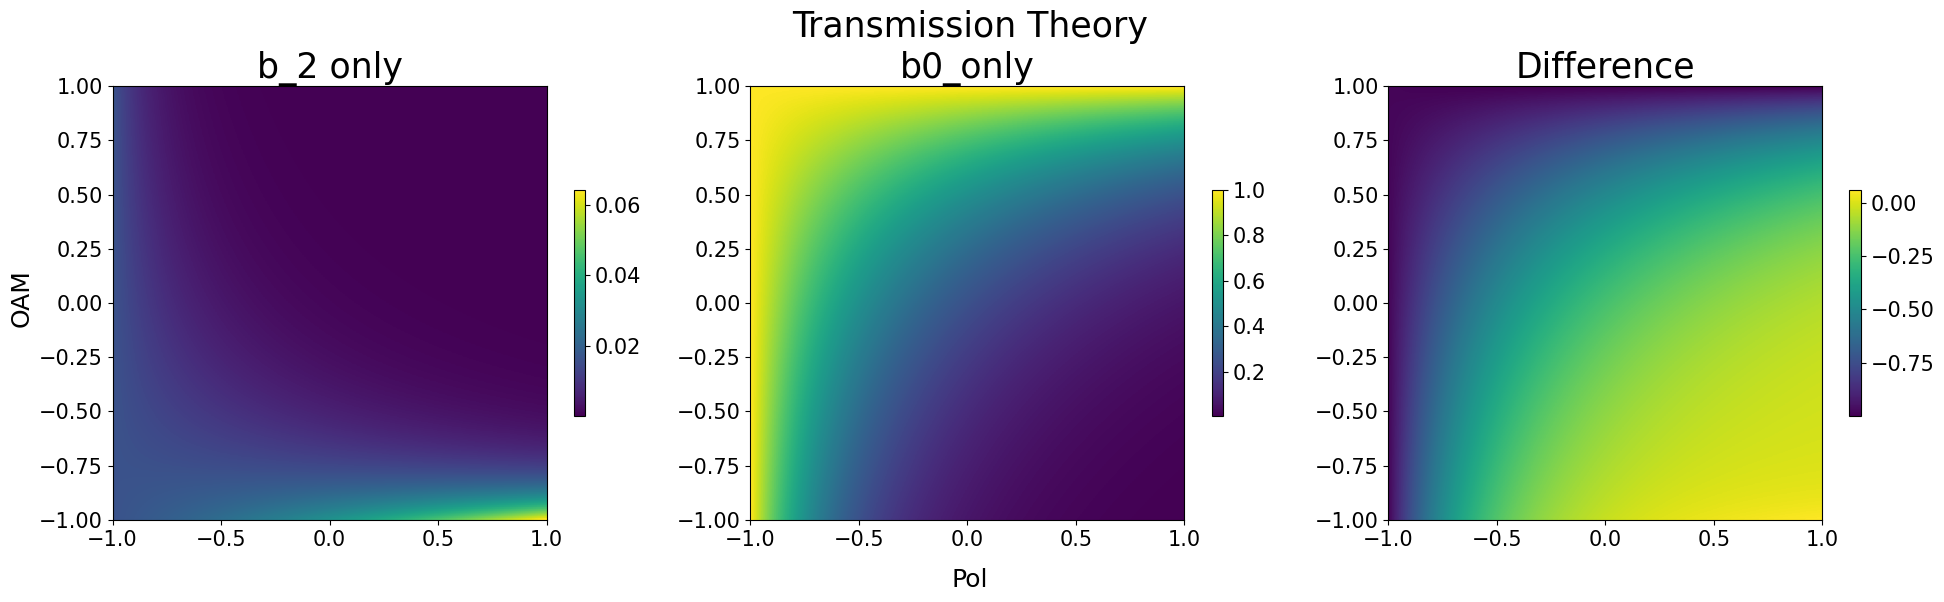

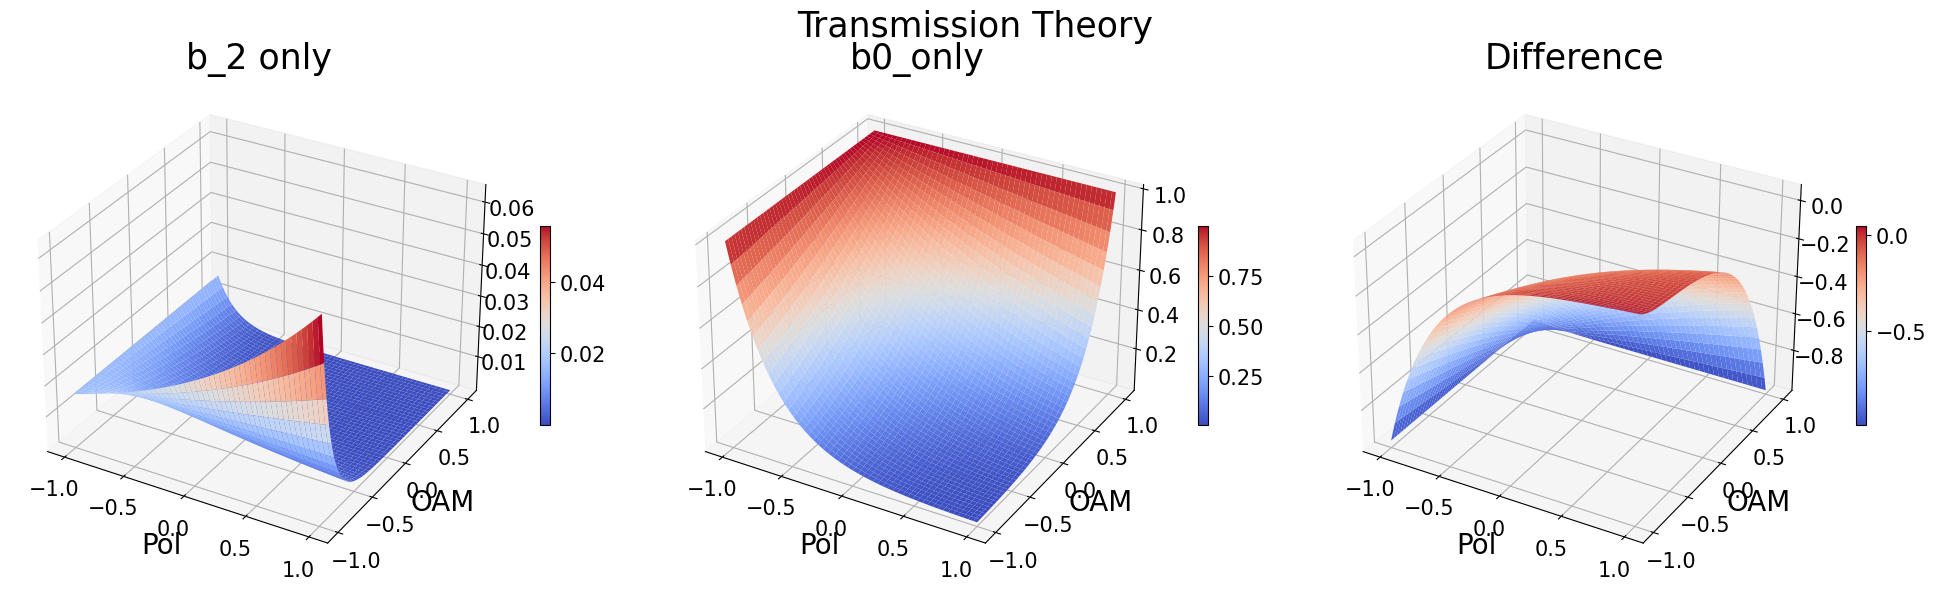

In [4]:
def plot_diff(first,second,twoD=False,threeD=False,title=['','',''],sp_space=np.linspace(-1,1,200),oam_space=np.linspace(-1,1,200)):
    """Compares two models of the transmission."""
    if twoD:
        fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,6))

        im1 = ax[0].imshow(first,extent=[sp_space[0],sp_space[-1],oam_space[0],oam_space[-1]],origin='lower')
        ax[0].set_title(title[0])
        plt.colorbar(im1,ax=ax[0],shrink=.5)

        im2 = ax[1].imshow(second,extent=[sp_space[0],sp_space[-1],oam_space[0],oam_space[-1]],origin='lower')
        ax[1].set_title(title[1])
        plt.colorbar(im2,ax=ax[1],shrink=.5)

        ax[2].set_title('Difference')
        im3 = ax[2].imshow(first-second,extent=[sp_space[0],sp_space[-1],oam_space[0],oam_space[-1]],origin='lower')
        plt.colorbar(im3,ax=ax[2],shrink=.5)

        fig.supxlabel('Pol')
        fig.supylabel('OAM')
        plt.suptitle(title[2])
        plt.tight_layout()
        plt.show()
    
    if threeD:
        fig = plt.figure(figsize=(20,6))
        ax1 = fig.add_subplot(1,3,1,projection='3d')
        SP,OM = np.meshgrid(sp_space,oam_space)
        im1 = ax1.plot_surface(SP,OM,first,cmap=cm.coolwarm)
        ax1.set_title(title[0])
        ax1.set_xlabel('Pol')
        ax1.set_ylabel('OAM')
        plt.colorbar(im1,ax=ax1,shrink=.4)
        #ax1.view_init(azim=0)

        ax2 = fig.add_subplot(1,3,2,projection='3d')
        SP,OM = np.meshgrid(sp_space,oam_space)
        im2 = ax2.plot_surface(SP,OM,second,cmap=cm.coolwarm)
        ax2.set_title(title[1])
        ax2.set_xlabel('Pol')
        ax2.set_ylabel('OAM')
        plt.colorbar(im2,ax=ax2,shrink=.4)
        #ax2.view_init(azim=-120)

        ax3 = fig.add_subplot(1,3,3,projection='3d')
        SP,OM = np.meshgrid(sp_space,oam_space)
        im3 = ax3.plot_surface(SP,OM,first-second,cmap=cm.coolwarm)
        ax3.set_title('Difference')
        ax3.set_xlabel('Pol')
        ax3.set_ylabel('OAM')
        plt.colorbar(im3,ax=ax3,shrink=.4)
        #ax3.view_init(azim=60)
        
        plt.suptitle(title[2])
        plt.tight_layout()
        plt.show()

sp_space=np.linspace(-1,1,200)
oam_space=np.linspace(-1,1,200)

trans_OAM = np.empty((200,200))
for o in range(200):
    for s in range(200):
        trans_OAM[o,s] = get_T(bulldog,spin_pol=sp_space[s],OAM_pol=oam_space[o],show=False)
        
b2_only = np.empty((200,200))
for o in range(200):
    for s in range(200):
        b2_only[o,s] = get_T(bulldog,spin_pol=sp_space[s],OAM_pol=oam_space[o],show=False,b_0=0,he_pol=1)
        
b0_only = np.empty((200,200))
for o in range(200):
    for s in range(200):
        b0_only[o,s] = get_T(bulldog,spin_pol=sp_space[s],OAM_pol=oam_space[o],show=False,b_2=0,he_pol=1)
    
trans = np.empty((200,200))
for o in range(200):
    for s in range(200):
        trans[o,s] = get_T(bulldog,spin_pol=sp_space[s],OAM_pol=oam_space[o],show=False,OAM=False)
        
#plot_diff(trans_OAM,trans,twoD=True,threeD=True,title=['OAM','No OAM','Transmission Theory'],sp_space=sp_space,oam_space=oam_space)
plot_diff(b2_only,b0_only,twoD=True,threeD=True,title=['b_2 only','b0_only','Transmission Theory'],sp_space=sp_space,oam_space=oam_space)

## Wavefunction analysis

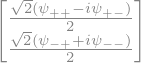

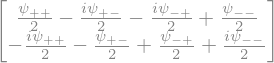

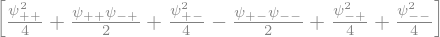

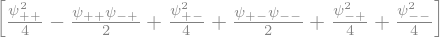

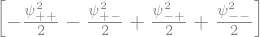

In [57]:
sym.init_printing()
pp,pm,mp,mm = sym.symbols(r'\psi_{++},\psi_{+-},\psi_{-+},\psi_{--}',real=True)

idt,spx,spy,spz = sym.eye(2),sym.Matrix([[0,1],[1,0]]),sym.Matrix([[0,-sym.I],[sym.I,0]]),sym.Matrix([[1,0],[0,-1]])
xp,xm = sym.Rational(1,2)*sym.Matrix([[1,1],[1,1]]),sym.Rational(1,2)*sym.Matrix([[1,-1],[-1,1]])
yp,ym = sym.Rational(1,2)*sym.Matrix([[1,-1*-1*sym.I],[-1*sym.I,1]]),sym.Rational(1,2)*sym.Matrix([[1,-1*sym.I],[-1*-1*sym.I,1]])
zp,zm = sym.Matrix([[1,0],[0,0]]),sym.Rational(1,2)*sym.Matrix([[0,0],[0,1]])

def rot(alpha,n):
    """Returns rotation matrix about n (must be normalized) given an angle alpha."""
    return sym.cos(alpha/2)*idt - sym.I*sym.sin(alpha/2)*(spx*n[0] + spy*n[1] + spz*n[2])

def measure(psi,oper,print=False):
    """Gets expectation from given wavefunction and operator."""
    result = sym.transpose(psi.applyfunc(sym.conjugate))*(oper*psi)
    result = result.applyfunc(sym.expand)
    result = result.applyfunc(sym.simplify)
    if print: display(result)
    return result

wf_0 = 1/sym.sqrt(2)*sym.Matrix([[pp - sym.I*pm],[mp + sym.I*mm]])
wf_0 = wf_0.applyfunc(sym.simplify)
display(wf_0)

wf_1 = rot(sym.pi/2,(1,0,0))*wf_0
wf_1 = wf_1.applyfunc(sym.simplify)
display(wf_1)

wf_2 = measure(wf_1,xp,print=True)
_ = measure(wf_1,xm,print=True)
_ = measure(wf_1,spx,print=True)
_ = measure(wf_1,spy,print=True)
_ = measure(wf_1,spz,print=True)

## Building the beamline

In [3]:
lambda0 = 4.25  #Mean wavelength (AA)
dlambda = lambda0*1/100

ap_width = 10.
ap_height = 10.

MWP_str = 6e-3  #MWP field strength (T/Amp)
NU_str = 1e-3
CRYO_str = 1e-3

MWP_dims = [.02,.02,.11]
NU_dims = [.03,.03,.03]
CRYO_dims = [.03,.03,.015]

MWP_sep = .006
NU_sep = .0125 + .015
CYRO_sep = .006

N1 = .15
C1 = N1 + NU_dims[2] + NU_sep
d1 = C1 + CRYO_dims[2] + CYRO_sep
d2 = d1 + MWP_dims[2] + MWP_sep
N2 = d2 + MWP_dims[2] + NU_sep
d3 = N2 + NU_dims[2] + NU_sep
d4 = d3 + MWP_dims[2] + MWP_sep
C2 = d4 + MWP_dims[2] + CYRO_sep
N3 = C2 + CRYO_dims[2] + NU_sep
det1 = N3 + NU_dims[2] + .15    #distance from sample position to detector1 (m)
ds = det1 + .3
det2 = ds + .6  #must be shorter than 3 meters
d = [N1,C1,d1,d2,N2,d3,d4,C2,N3,det1,ds,det2]

print(MWP_dims[2]*2+MWP_sep+CYRO_sep+CRYO_dims[2]+2*NU_sep)

print(f'Wavelength: {lambda0} p/m {round(dlambda,3)}')
print(f'Aperture (mm) = {ap_width,ap_height}')
print(f'Front distances from MWP to source (m): {np.round(d,3)}')

cur = get_sec(sel=100)
print(f'MWP currents: {cur}')

pol_dir = [1,0,0]    #direction of polarizer (x,y,z)
pol_dir = [i/np.sqrt(sum([j**2 for j in pol_dir])) for i in pol_dir]    
print('Polarizer axis: ', [round(i,3) for i in pol_dir])

det_x,det_y = 10.,10.
det_bins = 128

print(f'Detector size (mm): {np.round([det_x,det_y],3)}')
print('[x,y] bin size (mm) = ', [round(i,3) for i in [det_x/det_bins,det_y/det_bins]], '\n')

print("-"*80)     #Start of instrument definition
OAM = ms.McStas_instr('OAM', author = 'Sam McKay', origin = 'Indiana University')
delta_lambda = OAM.add_parameter("double", "delta_lambda", value = dlambda, comment="Wavelength spread [AA]")
low_count = OAM.add_parameter("int", "low_count", value = 0, comment="if true flips analyzer direction [N/A]")
all_off = OAM.add_parameter("int", "all_off", value = 0, comment="if true turns off all MWPs [N/A]")
cur1 = OAM.add_parameter("double", "cur1", value = cur, comment="MWP1 current [Amps]")
cur2 = OAM.add_parameter("double", "cur2", value = -cur, comment="MWP2 current [Amps]")
cur3 = OAM.add_parameter("double", "cur3", value = cur, comment="MWP3 current [Amps]")
cur4 = OAM.add_parameter("double", "cur4", value = -cur, comment="MWP4 current [Amps]")
polx = OAM.add_parameter("double", "polx", value = pol_dir[0], comment="x-component of polarizer [N/A]")
poly = OAM.add_parameter("double", "poly", value = pol_dir[1], comment="y-component of polarizer [N/A]")
polz = OAM.add_parameter("double", "polz", value = pol_dir[2], comment="z-component of polarizer [N/A]")
OAM.show_parameters()

print("-"*80)    #Source and polarizer (collimation included via source parameters):
OAM.add_component("origin","Progress_bar")
OAM.add_component("arm","Arm", AT=[0,0,0], RELATIVE="origin")

src = OAM.add_component("src","Source_sam", AT=[0,0,0], RELATIVE="origin")
src.set_parameters(xwidth=ap_width*1e-3,yheight=ap_height*1e-3,I1=1e13,lambda0=lambda0,dlambda="delta_lambda",\
                   focus_xw=det_x/1e3,focus_yh=det_y/1e3,x_offset=det_x_offset/1e3,dist=Ld)
print(src)
pol = OAM.add_component("pol","Set_pol", AT=[0,0,1e-6], RELATIVE="origin")
pol.set_parameters(px="polx", py="poly", pz="polz")

print(pol)

print("-"*80)    #First accelerator coil and nutator
NU1 = OAM.add_component("NU1","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
NU1.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(NU1)
AC1 = OAM.add_component("AC1","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
AC1.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(AC1)

print("-"*80)    #Magnetic Wollaston prisms:
MWP1 = OAM.add_component("MWP1","pol_MWP_FI_expansion_v2", AT=[0,0,d[0]], RELATIVE="origin")
MWP1.set_parameters(xwidth=MWP_dims[0], yheight=MWP_dims[1], zdepth=MWP_dims[2], \
                    current="cur1*(1-all_off)")
MWP2 = OAM.add_component("MWP2","pol_MWP_FI_expansion_v2", AT=[0,0,d[1]], RELATIVE="origin")
MWP2.set_parameters(xwidth=MWP_dims[0], yheight=MWP_dims[1], zdepth=MWP_dims[2], \
                    current="cur2*(1-all_off)")
MWP3 = OAM.add_component("MWP3","pol_MWP_FI_expansion_v2", AT=[0,0,d[2]], RELATIVE="origin")
MWP3.set_parameters(xwidth=MWP_dims[0], yheight=MWP_dims[1], zdepth=MWP_dims[2], \
                    current="cur3*(1-all_off)")
MWP4 = OAM.add_component("MWP4","pol_MWP_FI_expansion_v2", AT=[0,0,d[3]], RELATIVE="origin")
MWP4.set_parameters(xwidth=MWP_dims[0], yheight=MWP_dims[1], zdepth=MWP_dims[2], \
                    current="cur4*(1-all_off)")
MWP1.set_ROTATED([0, 0, 0], RELATIVE="ABSOLUTE")
MWP2.set_ROTATED([0, 0, 0], RELATIVE="ABSOLUTE")
MWP3.set_ROTATED([0, 0, 90], RELATIVE="ABSOLUTE")
MWP4.set_ROTATED([0, 0, 90], RELATIVE="ABSOLUTE")
print(MWP1,'\n', MWP2)
print(MWP3, '\n', MWP4)

print("-"*80)    #Second accelerator coil and nutator
AC2 = OAM.add_component("AC2","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
AC2.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(AC2)
NU2 = OAM.add_component("NU2","Pol_constBfield", AT=[0,0,dists['CG']], RELATIVE="origin")
NU2.set_parameters(xwidth=CG_dim['x'], yheight=CG_dim['y'], zdepth=CG_dim['z'], \
                    B="BCG*(1-all_off)")
print(NU2)

print("-"*80)    #Detectors and sample:
ana = OAM.add_component("ana","PolAnalyser_ideal", AT=[0, 0, Ld - (Ls + 2e-6)], RELATIVE="origin")
ana.set_parameters(mx=0, my=0, mz="polx*(1-2*low_count)")
ana.set_ROTATED([0, 0, 0], RELATIVE="ABSOLUTE")
print(ana)

twoD_det = OAM.add_component("twoD_det","PSD_monitor", AT=[det_x_offset/1e3, 0, Ld + 2e-6], RELATIVE="origin")
twoD_det.set_parameters(nx=det_bins, ny=det_bins, filename=twoD_file, xwidth=det_x*1e-3, yheight=det_y*1e-3)
print(twoD_det)

print("-"*80)    #Final instrument summary:
OAM.show_components()

0.302
Wavelength: 4.25 p/m 0.043
Aperture (mm) = (10.0, 10.0)
Front distances from MWP to source (m): [0.15  0.208 0.228 0.344 0.482 0.54  0.656 0.772 0.814 0.994 1.294 1.894]
MWP currents: 11.38
Polarizer axis:  [1.0, 0.0, 0.0]
Detector size (mm): [10. 10.]
[x,y] bin size (mm) =  [0.078, 0.078] 

--------------------------------------------------------------------------------
double delta_lambda  = 0.0425  // Wavelength spread [AA]
int    low_count     = 0       // if true flips analyzer direction [N/A]
int    all_off       = 0       // if true turns off all MWPs [N/A]
double cur1          = 11.38   // MWP1 current [Amps]
double cur2          = -11.38  // MWP2 current [Amps]
double cur3          = 11.38   // MWP3 current [Amps]
double cur4          = -11.38  // MWP4 current [Amps]
double polx          = 1.0     // x-component of polarizer [N/A]
double poly          = 0.0     // y-component of polarizer [N/A]
double polz          = 0.0     // z-component of polarizer [N/A]
------------

NameError: No component named Progress_bar in McStas installation or current work directory.

## Simulation scans

Currents =  [10, -11.192, 7.202, -8.394]
INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_hc_10_5"
INFO: Regenerating c-file: OAM.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_MWP_FI_expansion_v2' is a contributed component.
CFLAGS=
INFO: Recompiling: OAM.exe
OAM.c: In function 'mcuse_dir':
OAM.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
OAM.c: In function 'sighandler':
OAM.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy OAM.instr in dataset C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_hc_10_5



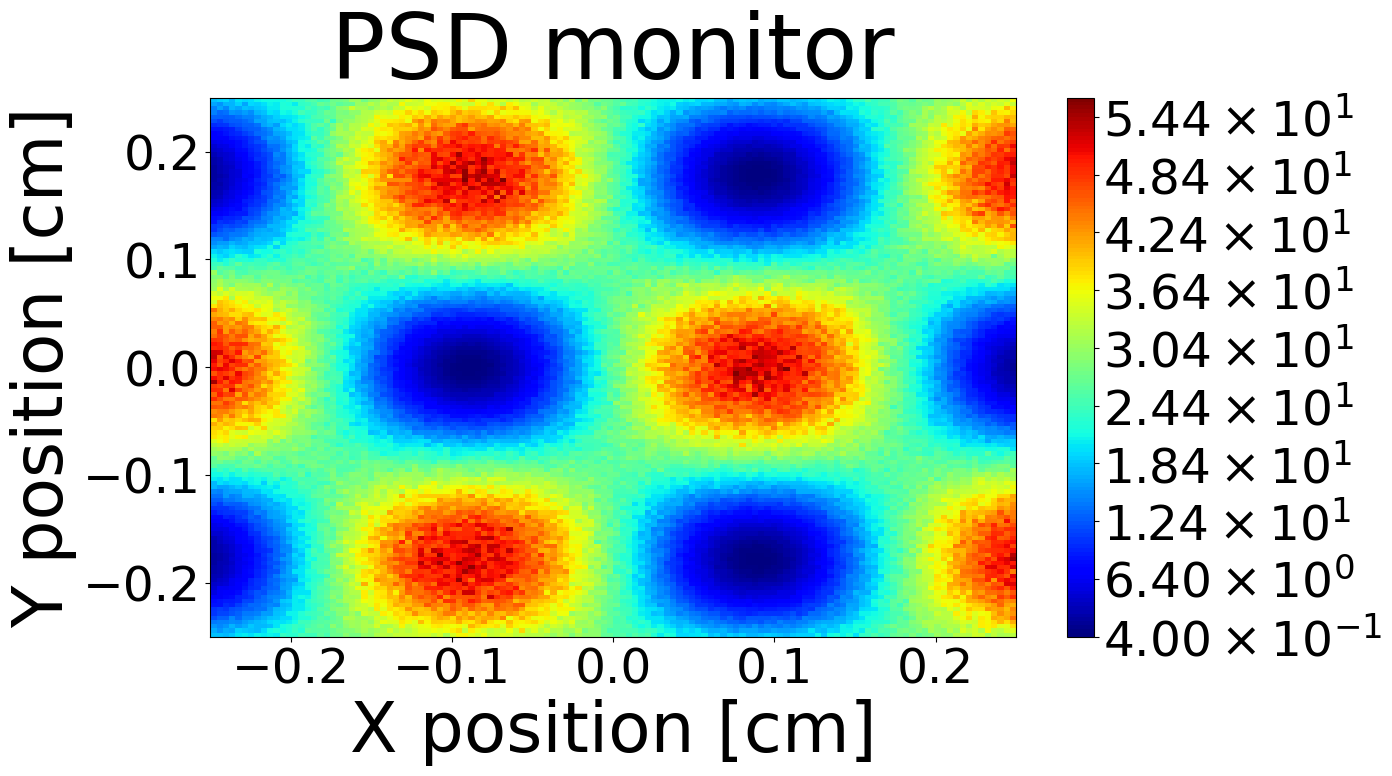

INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_lc_10_5"
INFO: Regenerating c-file: OAM.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_MWP_FI_expansion_v2' is a contributed component.
CFLAGS=
INFO: Recompiling: OAM.exe
OAM.c: In function 'mcuse_dir':
OAM.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
OAM.c: In function 'sighandler':
OAM.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy OAM.instr in dataset C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_lc_10_5


----------------------------------------

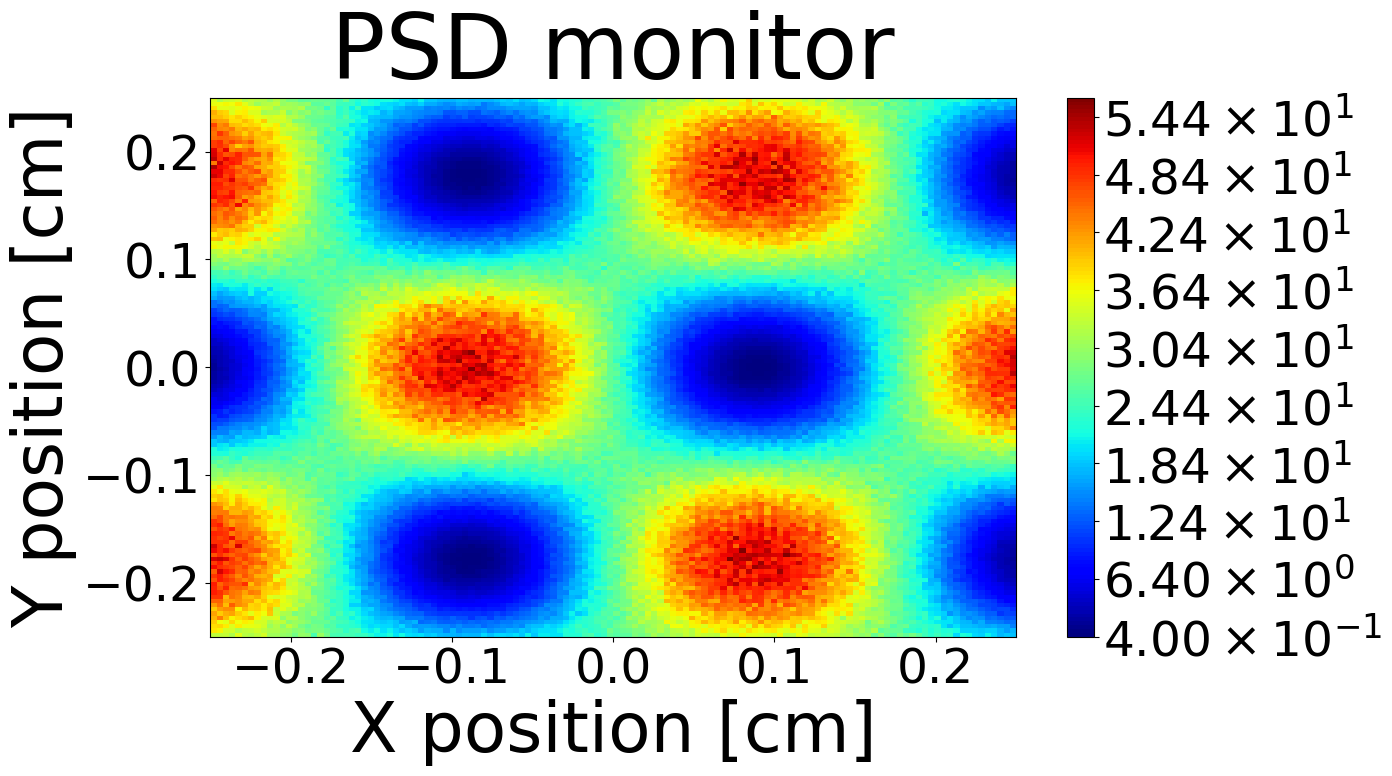


Currents =  [40, -44.768, 28.808, -33.576]
INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_hc_40_0"
INFO: Regenerating c-file: OAM.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_MWP_FI_expansion_v2' is a contributed component.
CFLAGS=
INFO: Recompiling: OAM.exe
OAM.c: In function 'mcuse_dir':
OAM.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
OAM.c: In function 'sighandler':
OAM.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy OAM.instr in dataset C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_hc_40_

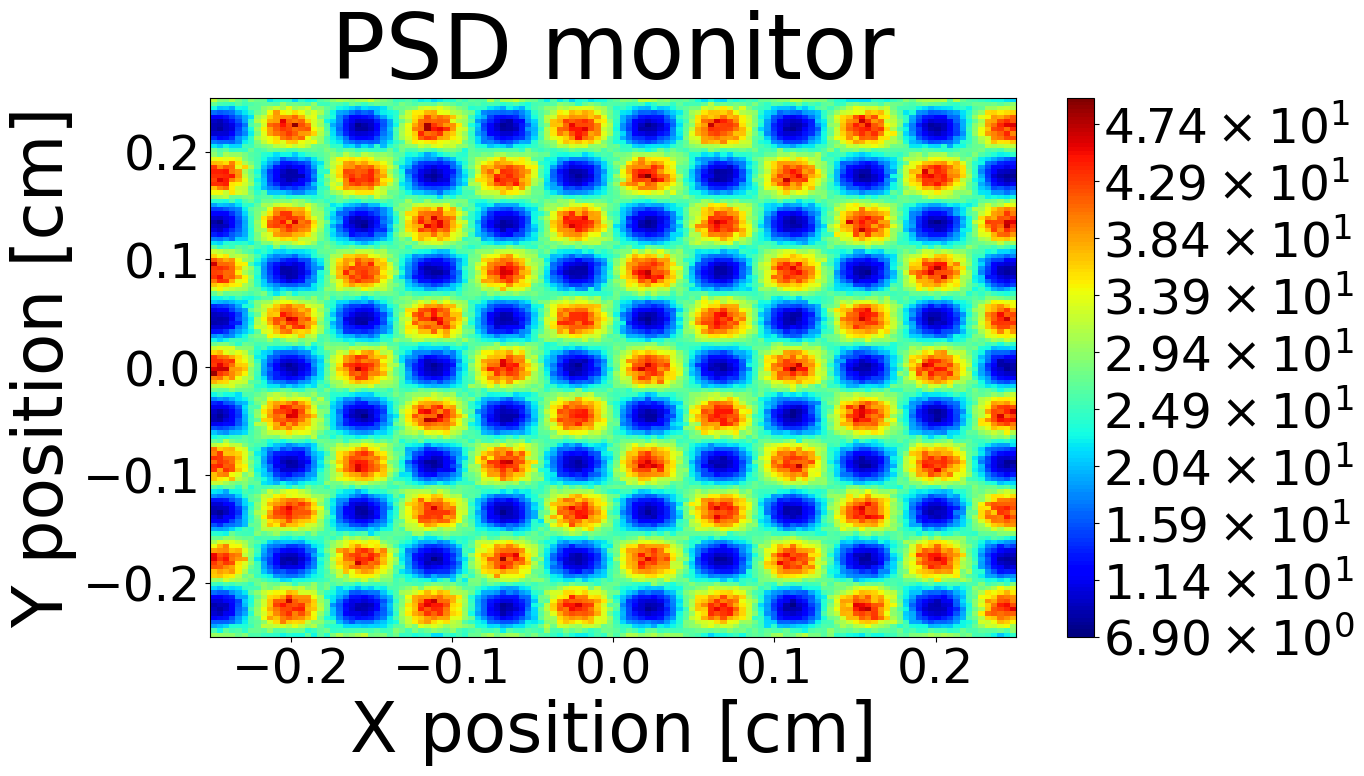

INFO: Using directory: "C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_lc_40_0"
INFO: Regenerating c-file: OAM.c
Info:    'Source_sam' is a contributed component.
Info:    'pol_MWP_FI_expansion_v2' is a contributed component.
CFLAGS=
INFO: Recompiling: OAM.exe
OAM.c: In function 'mcuse_dir':
OAM.c:3419:8: warning: implicit declaration of function 'mkdir' [-Wimplicit-function-declaration]
     if(mkdir(dirname, 0777)) {
        ^~~~~
OAM.c: In function 'sighandler':
OAM.c:5325:64: warning: implicit declaration of function 'getpid'; did you mean 'gets_s'? [-Wimplicit-function-declaration]
   printf("\n# " MCCODE_STRING ": [pid %i] Signal %i detected", getpid(), sig);
                                                                ^~~~~~
                                                                gets_s
INFO: ===
INFO: Placing instr file copy OAM.instr in dataset C:\Users\samck\Documents\Scripts\McStas\Beamlines\a_OAM\OAM_lc_40_0


----------------------------------------

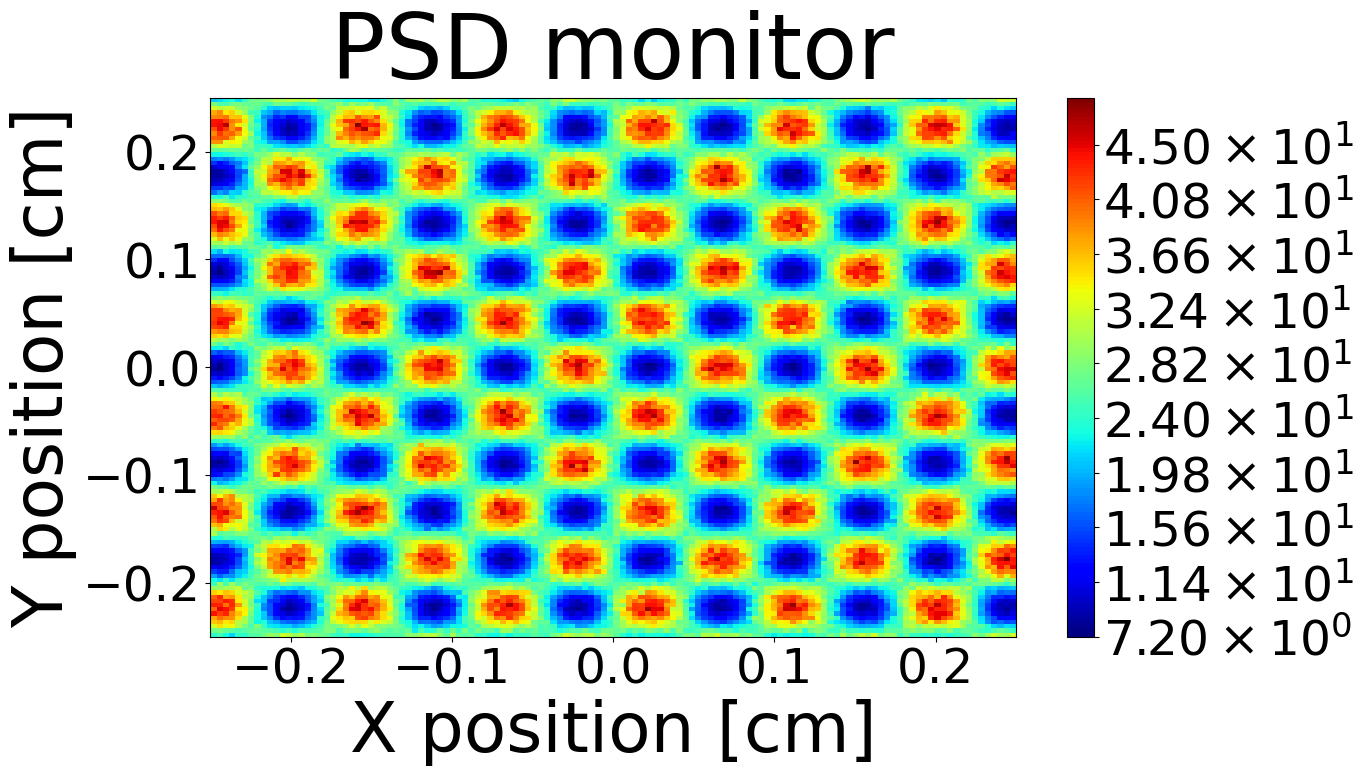

In [5]:
def do_run(ray_num, curs):
    """Runs the two necessary simulations to extract the polarization.
    Returns high and low counts and errors and all used currents."""
    used_curs = []
    hc_runs, hc_err = [[],[]]
    lc_runs, lc_err = [[],[]]

    for i in curs:
        c1 = i
        c2, c3, c4 = get_ch(i, L1, L2, L3, L4)
        used_curs.append([c1,c2,c3,c4])
        print('Currents = ', [round(i,3) for i in [c1,c2,c3,c4]])

        OAM.settings(output_path='OAM_hc_'+str(round(c1,2)), ncount=ray_num)
        low_count.value, all_off.value, cur1.value, cur2.value, cur3.value, cur4.value = 0, 0, c1, c2, c3, c4
        OAM_hc = OAM.backengine()
        hc_runs.append(OAM_hc[-1].Intensity)    #only LAST detector is returned
        hc_err.append(OAM_hc[-1].Error)
        ms.make_plot(OAM_hc)

        OAM.settings(output_path='OAM_lc_'+str(round(c1,2)))
        low_count.value = 1
        OAM_lc = OAM.backengine()
        lc_runs.append(OAM_lc[-1].Intensity)
        lc_err.append(OAM_lc[-1].Error)
        ms.make_plot(OAM_lc)
        print('='*80, '\n')
    return used_curs, hc_runs, hc_err, lc_runs, lc_err
        
used_curs, hc_runs, hc_err, lc_runs, lc_err = do_run(1e7, [10,40])


## Simulation Analysis
***

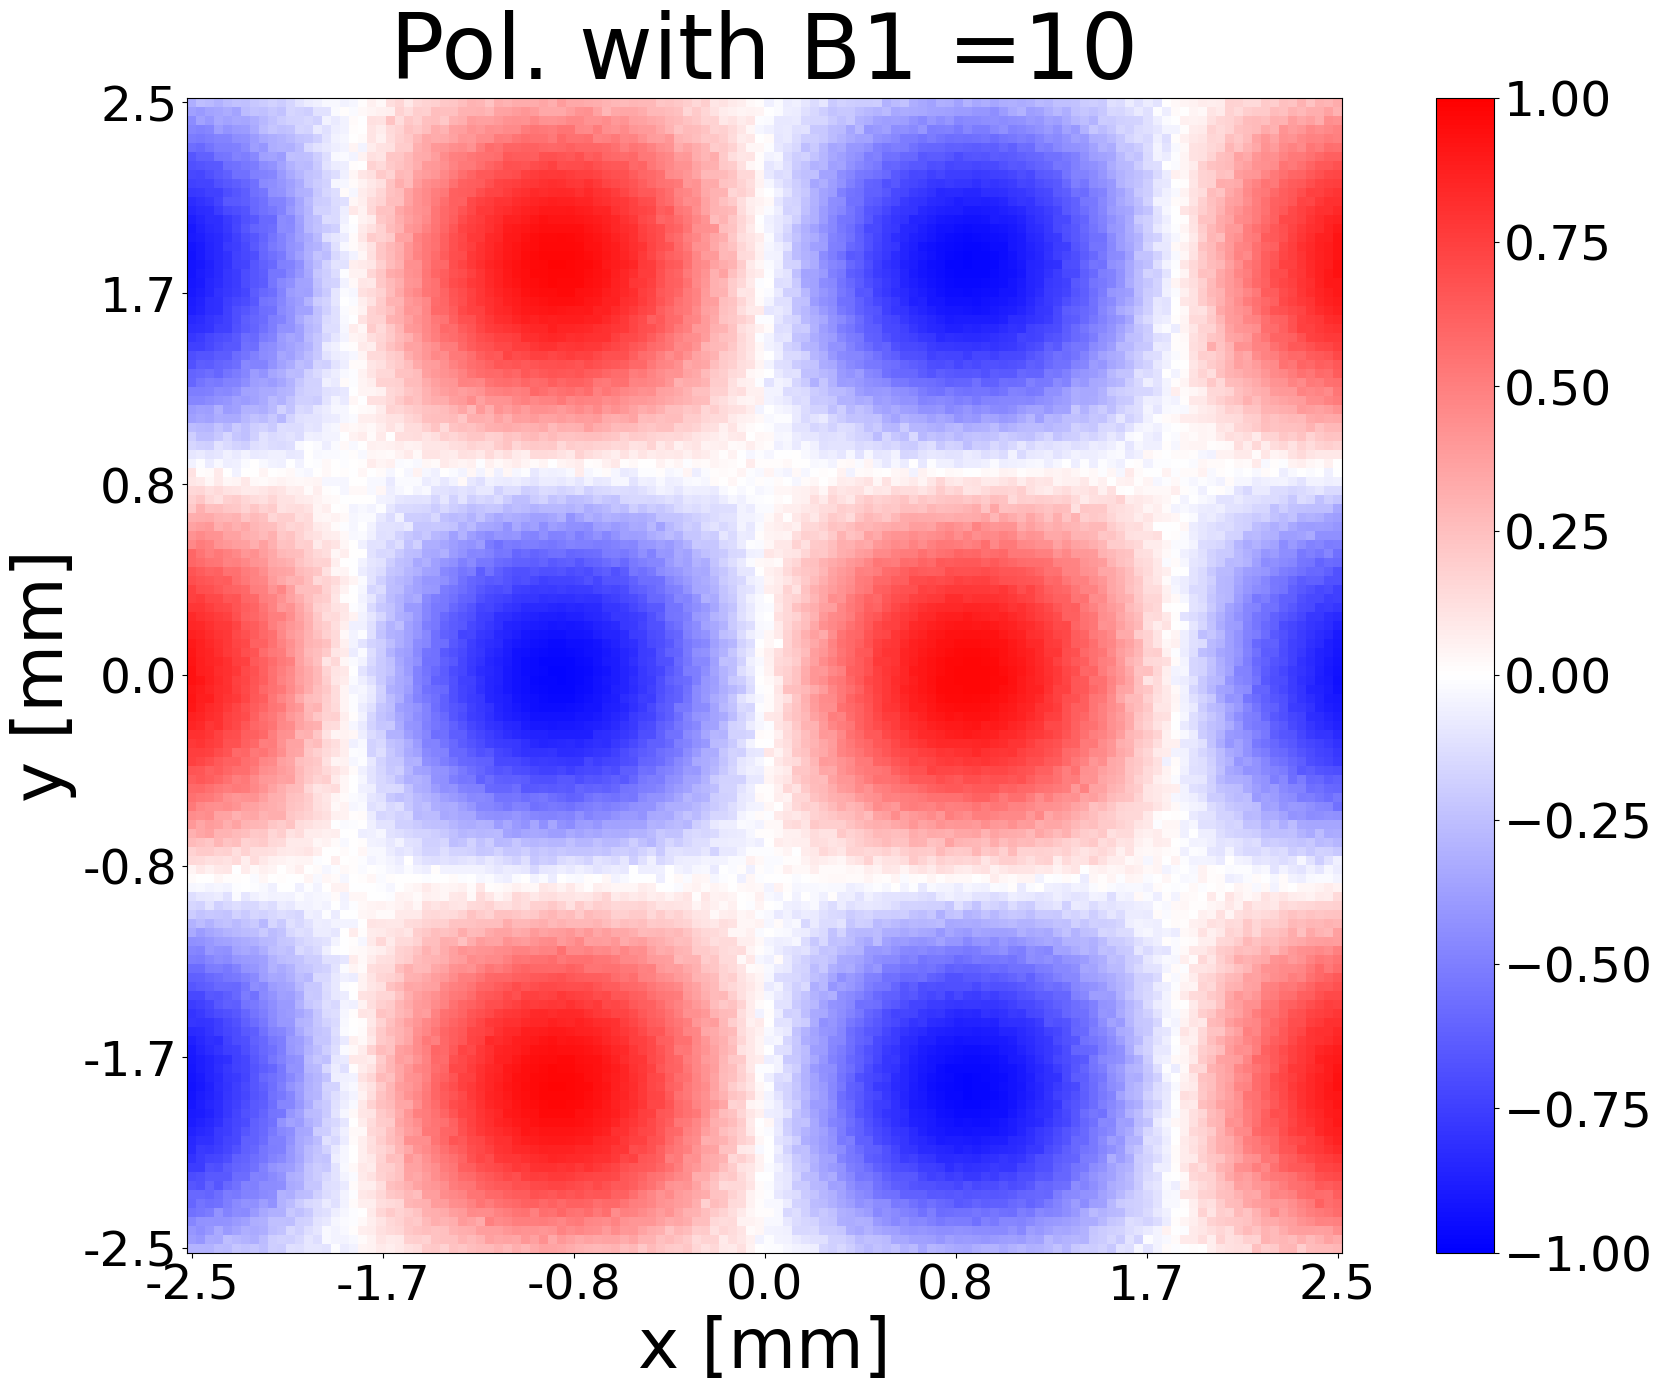

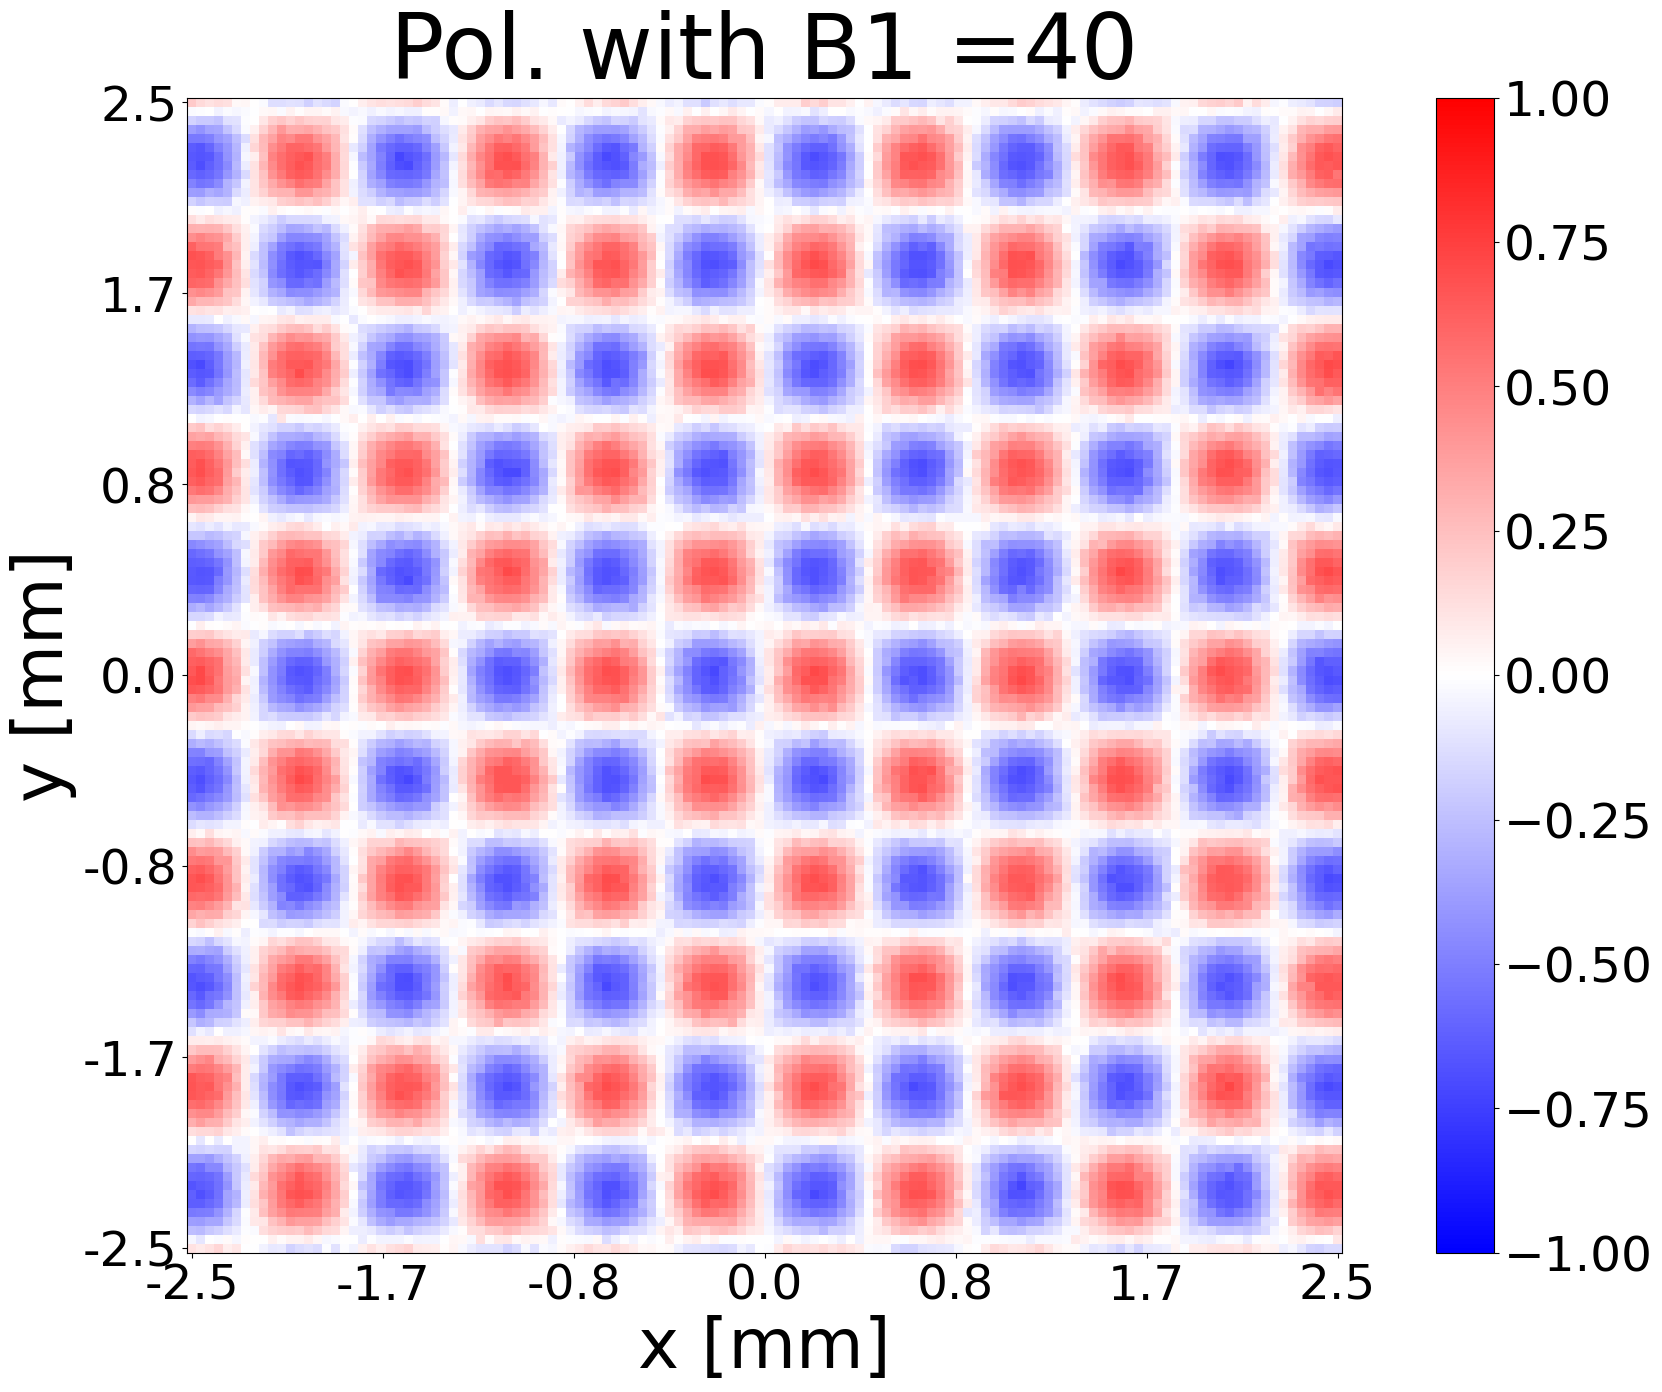

In [8]:
xpos = np.linspace(-det_x/2,det_x/2, num=det_bins, endpoint=True)
fine_bins = 200
finer_bins = 1000
xpos_fine = np.linspace(xpos[0], xpos[-1], num=fine_bins, endpoint=True)
xpos_finer = np.linspace(xpos[0], xpos[-1], num=finer_bins, endpoint=True)
pols = np.array([np.zeros((det_bins,det_bins)) for i in range(len(hc_runs))])

for i in range(len(used_curs)): #don't change this!
    for j in range(det_bins):
        for k in range(det_bins):
            pols[i][j][k] = ((hc_runs[i][j][k] - lc_runs[i][j][k])\
                             /(hc_runs[i][j][k] + lc_runs[i][j][k]))
                
    fig = plt.figure(figsize=(plot_width,plot_height))
    ax = plt.axes()
    plt.title('Pol. with B1 ='+str(used_curs[i][0]))
    plt.imshow(pols[i], origin='lower', vmin=-1, vmax=1, interpolation='none', cmap='bwr')
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    ax.set_xticks(np.linspace(0,det_bins-1,7))
    ax.set_yticks(np.linspace(0,det_bins-1,7))
    ax.set_xticklabels([round(i,1) for i in np.linspace(-det_x/2,det_x/2,7)])
    ax.set_yticklabels([round(i,1) for i in np.linspace(-det_y/2,det_y/2,7)])
    plt.colorbar()
    plt.show()


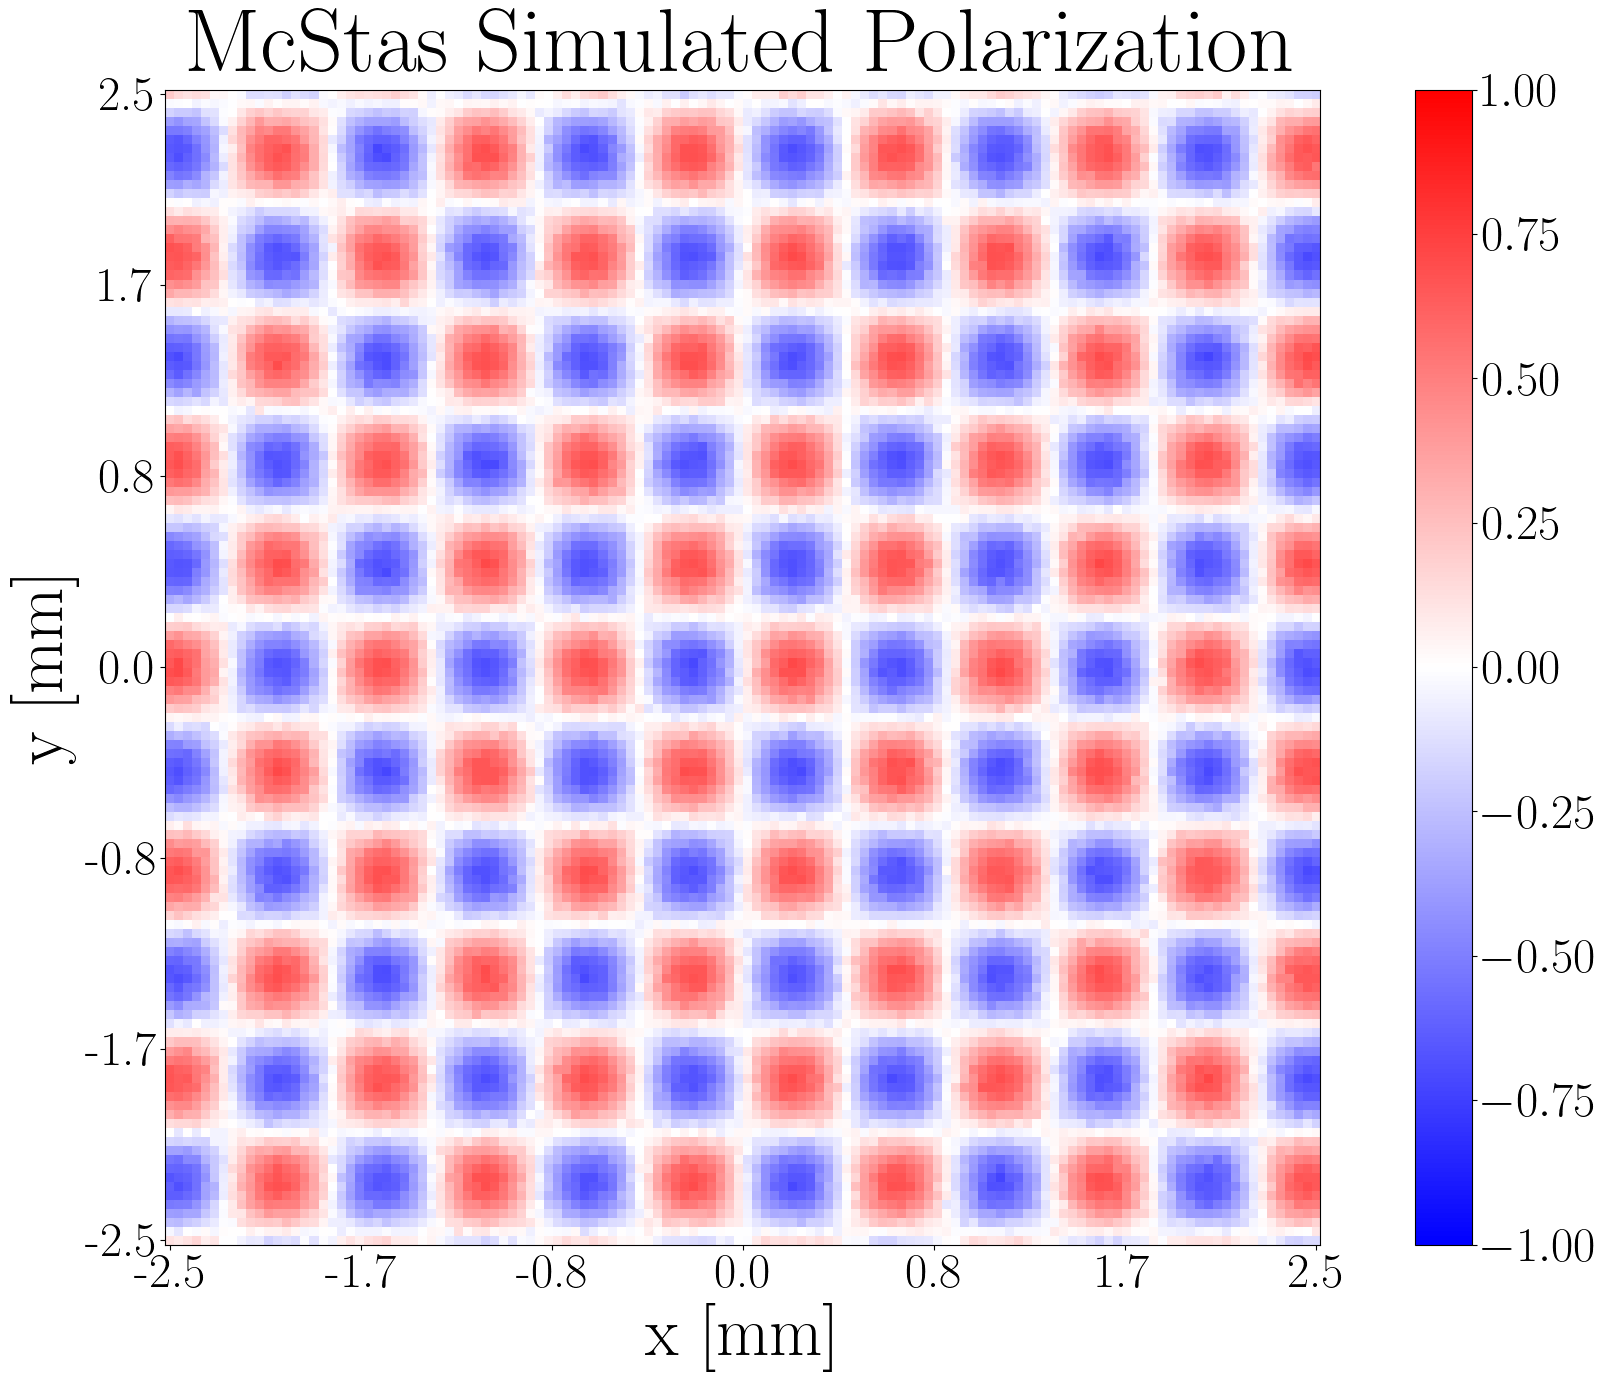

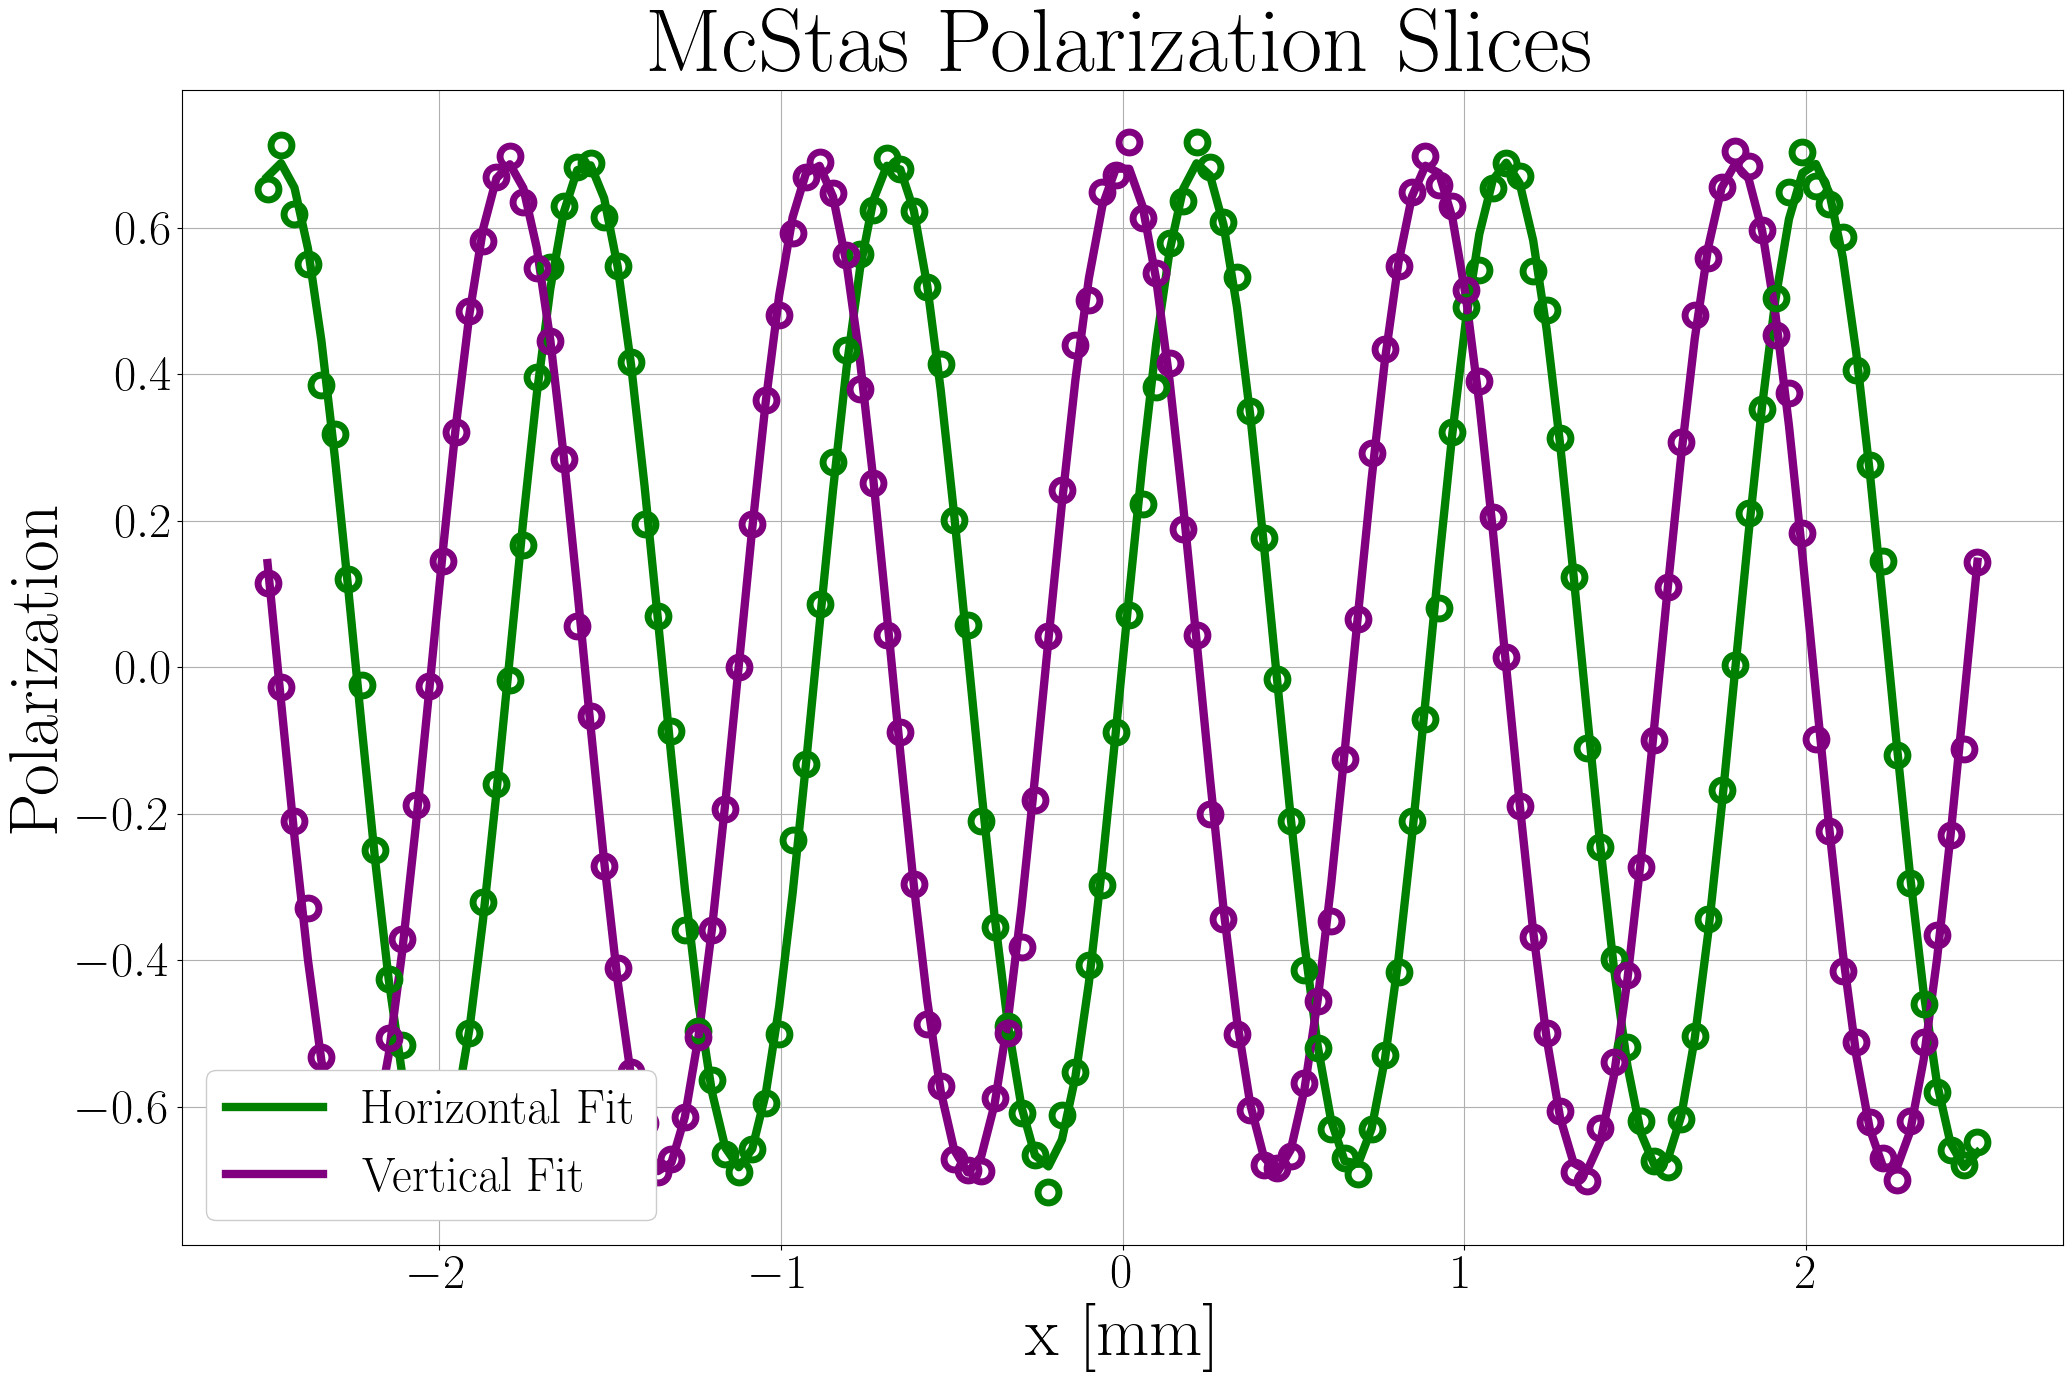

In [66]:
x_mg, y_mg = np.meshgrid(xpos, xpos)
def cb_theory(x,y,p):
    """Generates theorectical checkerboard spin-texture."""
    r_0 = p/(np.pi)
    z = -2*np.cos(2*y/r_0)*np.cos(x/r_0)*np.sin(x/r_0)
    return z

def get_p(c):
    """Returns theorectical fringe period."""
    return abs(2*np.pi/(cL*lambda0*MWP_str*(c[0] + c[1])))*1e3
cb_th = cb_theory(x_mg,y_mg,get_p(used_curs[-1]))

plot_im, plot_3D = True, False

if plot_im:
    """fig = plt.figure(figsize=(plot_width,plot_height))
    ax = plt.axes()
    plt.title('Theory')
    plt.imshow(cb_th, origin='lower', vmin=-1, vmax=1,interpolation='none', cmap='bwr')
    plt.colorbar()
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    ax.set_xticks(np.linspace(0,det_bins-1,7))
    ax.set_yticks(np.linspace(0,det_bins-1,7))
    ax.set_xticklabels([round(i,1) for i in np.linspace(-det_x/2,det_x/2,7)])
    ax.set_yticklabels([round(i,1) for i in np.linspace(-det_y/2,det_y/2,7)])
    plt.show()"""

    fig = plt.figure(figsize=(plot_width,plot_height))
    ax = plt.axes()
    plt.title('McStas Simulated Polarization')
    plt.imshow(pols[-1], origin='lower', vmin=-1, vmax=1, interpolation='none', cmap='bwr')
    plt.colorbar()
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    ax.set_xticks(np.linspace(0,det_bins-1,7))
    ax.set_yticks(np.linspace(0,det_bins-1,7))
    ax.set_xticklabels([round(i,1) for i in np.linspace(-det_x/2,det_x/2,7)])
    ax.set_yticklabels([round(i,1) for i in np.linspace(-det_y/2,det_y/2,7)])
    #plt.axhline(y=63.5, linewidth=5, linestyle='--', color='green')
    #plt.axvline(x=69.25, linewidth=5, linestyle='--', color='purple')
    plt.show()

    fig = plt.figure(figsize=(plot_width,plot_height))
    ax = plt.axes()
    plt.title('McStas Polarization Slices')
    plt.plot(xpos, pols[-1][64,:], 'o', ms=15, color='green', zorder=10, markerfacecolor='none', markeredgewidth=5)
    guess = [(np.max(pols[-1][64,:])-np.min(pols[-1][64,:]))/2.,2*np.pi/1,0,np.mean(pols[-1][64,:])]
    fit, cov = sp.optimize.curve_fit(simple_cos, xpos, pols[-1][64,:], p0=guess)
    plt.plot(xpos, simple_cos(xpos, *fit), '-', linewidth=6, color='green', label='Horizontal Fit')
    
    plt.plot(xpos, pols[-1][:,69], 'o', ms=15, color='purple', zorder=15, markerfacecolor='none', markeredgewidth=5)
    guess = [(np.max(pols[-1][:,69])-np.min(pols[-1][:,69]))/2.,2*np.pi/1,0,np.mean(pols[-1][:,69])]
    fit, cov = sp.optimize.curve_fit(simple_cos, xpos, pols[-1][:,69], p0=guess)
    plt.plot(xpos, simple_cos(xpos, *fit), '-', linewidth=6, color='purple', label='Vertical Fit')
    
    plt.xlabel('x [mm]')
    plt.ylabel('Polarization')
    plt.legend(loc='lower left', framealpha=1).set_zorder(20)
    plt.grid()
    plt.show()
    
if plot_3D:
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    #ax.view_init(60, 35)
    ax.contour3D(xpos,xpos,pols[0], 100, cmap='plasma')
    plt.show()

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(x_mg,y_mg,cb_th, rstride=1, cstride=1, cmap='plasma', edgecolor='none')
    plt.show()


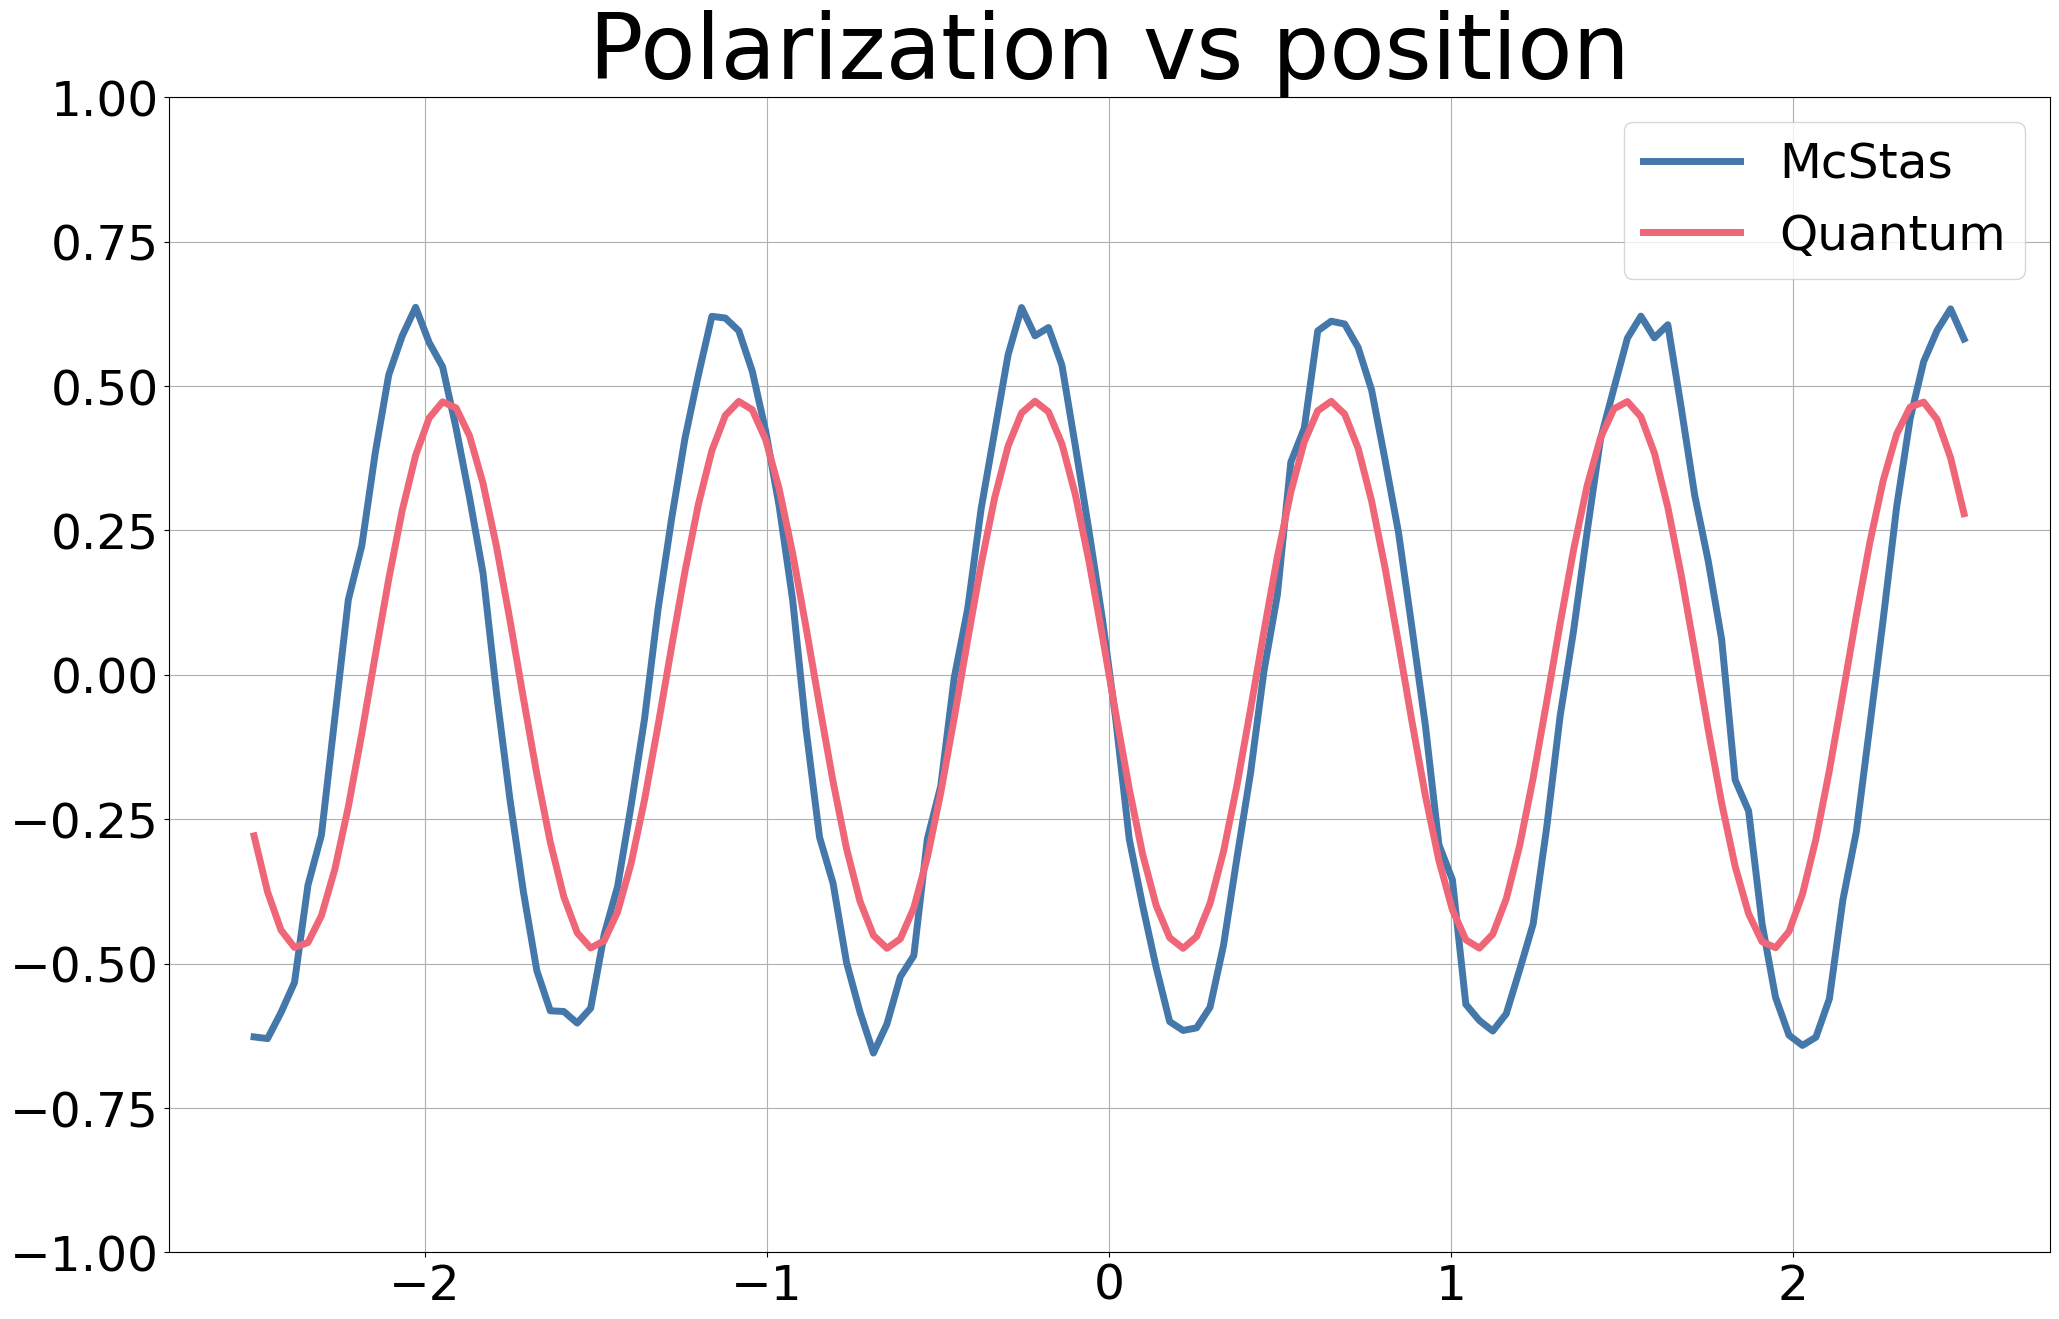

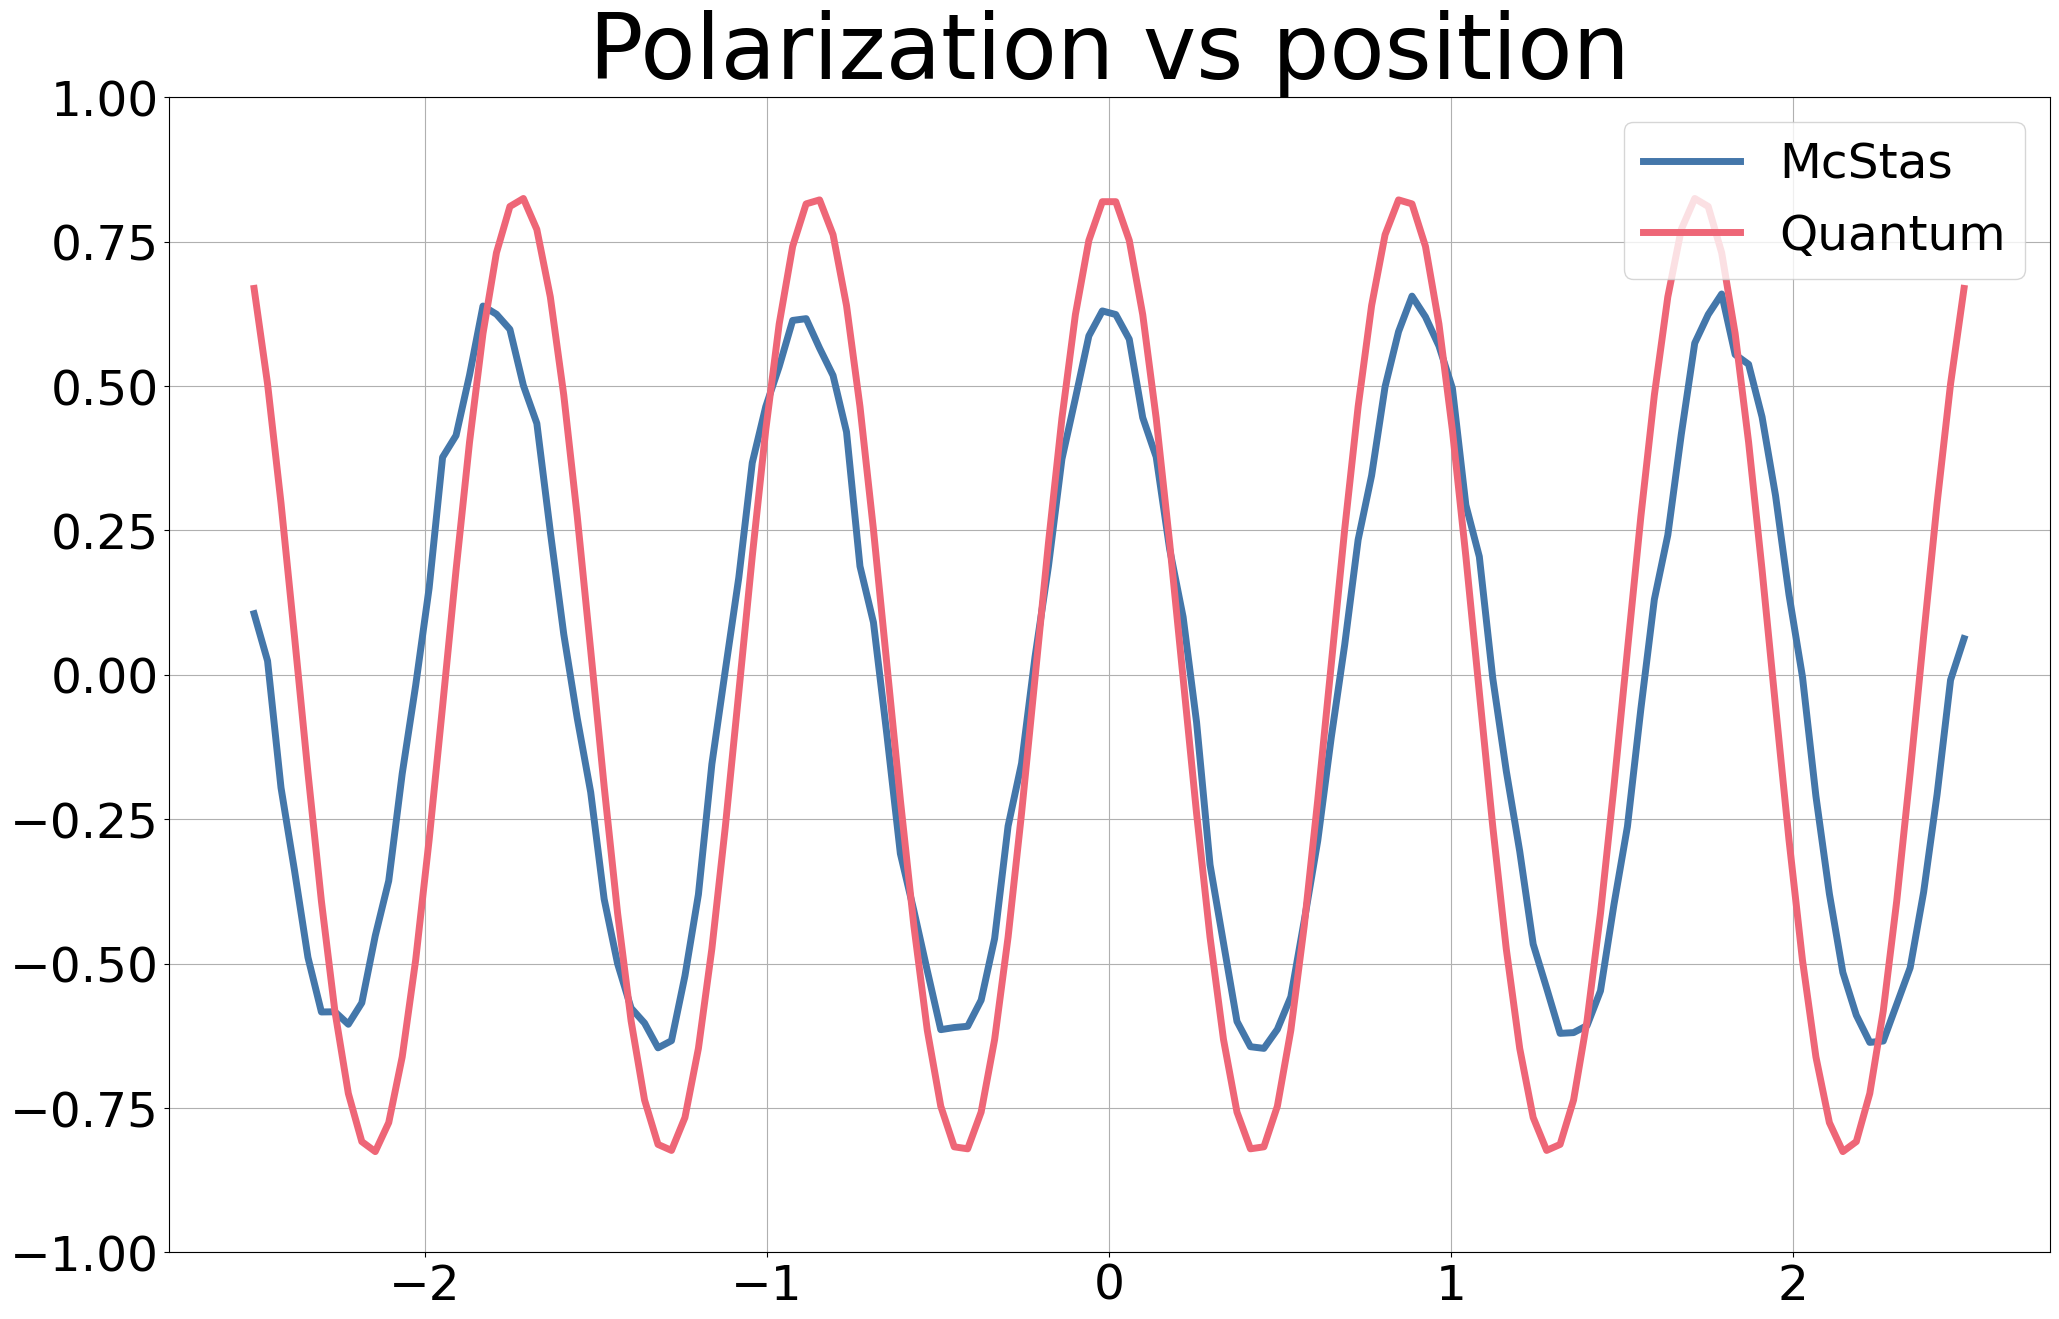

In [10]:
fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
plt.title('Polarization vs position')
plt.plot(xpos,pols[1,5,:], linewidth=5, label='McStas')
plt.plot(xpos, -cb_theory(xpos,xpos[5],get_p(used_curs[1])), linewidth=5, label='Quantum')
ax.set_ylim(-1,1)
plt.legend()
plt.grid()
plt.show()

fig = plt.figure(figsize=(plot_width,plot_height))
ax = plt.axes()
plt.title('Polarization vs position')
plt.plot(xpos,pols[1,:,45], linewidth=5, label='McStas')
plt.plot(xpos, -cb_theory(xpos[45],xpos,get_p(used_curs[1])), linewidth=5, label='Quantum')
ax.set_ylim(-1,1)
plt.legend()
plt.grid()
plt.show()


## Experiment Data Analysis:
***

In [5]:
def get_tr(mon,det,plot=True,title='',ac_range=[-2.5,2.5,-2.5,2.5],contrast=False):
    """Gets the normalized transmission."""
    if contrast:
        mon = mon/np.mean(mon)
        det = det/np.mean(det)
        rT = det/mon
    else: rT = det/mon/np.max(det/mon)
    if plot:
        fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(20,7))
        
        ax[0].set_title('Monitor T')
        im1 = ax[0].imshow(mon,extent=ac_range,origin='lower')
        plt.colorbar(im1,ax=ax[0],shrink=.8)

        ax[1].set_title('Detector T')
        im2 = ax[1].imshow(det,extent=ac_range,origin='lower')
        plt.colorbar(im2,ax=ax[1],shrink=.8)

        ax[2].set_title('Relative T')
        im3 = ax[2].imshow(rT,extent=ac_range,origin='lower')
        plt.colorbar(im3,ax=ax[2],shrink=.8)
        
        fig.supxlabel('ac_2')
        fig.supylabel('ac_1')
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()

    return det/mon

In [16]:
def get_pol(fr):
    """Converts flipping ratio to polarization."""
    return (fr - 1)/(1 + fr)

def get_scan(number):
    """Returns the data file scan number in Spice format."""
    const = 3
    if (number > 999):    #no leading zeros
        zeros = 0
    else:
        if (number == 0):
            zeros = const
        else:
            zeros = const - int(math.floor(math.log10(number)))
    return '0'*zeros + str(number)

default_order = ['det','det rate','mon rate','ac_1','ac_2','up_1','down_1','arm_2','detector','monitor','time','nu_1','nu_2','nu_3',\
                'rots','trans','sgl','sgu','stl','stu','a1','a2','focal_length','m1','m2','mfocus','cav_trans','s1','s2',\
                'q','h','k','l','ei','ef','e','nu_1_current','ac_1_current','prism_current','nu_2_current','ac_2_current','nu_3_current']

default_order = ['det','det rate','mon rate','ac_1','ac_2','up_1','down_1','up_2','down_2','detector','monitor','time',\
                'rots','trans','sgl','sgu','stl','stu','a1','a2','focal_length','m1','m2','mfocus','cav_trans','s1','s2',\
                'q','h','k','l','ei','ef','e','nu_1_current','ac_1_current','prism_current','nu_2_current','ac_2_current','nu_3_current']

default_order = ['det','det rate','mon rate','ac_1','ac_2','up_1','down_1','up_2','down_2','detector','monitor','time',\
                'cav_rot','cav_trans','sgl','sgu','stl','stu','a1','a2','focal_length','m1','m2','mfocus','cav_trans','s1','s2',\
                'q','h','k','l','ei','ef','e','nu_1_current','ac_1_current','prism_current','nu_2_current','ac_2_current','nu_3_current']


default_dict = {i[1]:i[0] for i in enumerate(default_order)}

useful_order = default_order[:12]
useful_dict = {i[1]:i[0] for i in enumerate(useful_order)}

def load_data(path, names, dest, write_data=False,overwrite=False,reorder=False):
    """Returns the list [scan number, scan date, scan time start, user input scan titles, matrix of data from scan].
    Cuts out all of the worthless parameters that we can't remove from SPICE for some reason."""
    scan_nums,dates,times,scan_titles,parms,data =[[],[],[],[],[],[]]
    for i in range(len(names)):
        file = open(path + names[i])
        lines = file.readlines()
        lines = [i.replace('\n','') for i in lines]    #removes new line characters
        file.close()
        
        scan_nums.append(lines[0][2::])    #line number determined by Spice format
        scan_nums[i] = scan_nums[i].split(' = ',)[1]
        dates.append(lines[1][2::])
        dates[i] = dates[i].split(' = ',)[1]
        times.append(lines[2][2::])
        times[i] = times[i].split(' = ',)[1]
        scan_titles.append(lines[10][2::])
        scan_titles[i] = scan_titles[i].split(' = ',)[1]
        parms.append(lines[29][7::].split())
        parms[i].append('det rate')
        parms[i].append('mon rate')
        data.append([j.split()[1::] for j in lines[30::] if (j[0] != '#')])    #assigns the data
        data[i] = [[float(data[i][j][k]) for j in range(len(data[i]))] for k in range(len(data[i][0]))]#HERE'S THE BUG    #converts to float
        data[i] = [list(j) for j in zip(*data[i])]    #transposes table
        
        time_normed_counts = [data[i][j][2]/data[i][j][1] if (data[i][j][1] != 0) else 0 for j in range(len((data[i])))]
        for j in range(len(data[i])):
            data[i][j].append(time_normed_counts[j])
            
        time_normed_counts2 = [data[i][j][3]/data[i][j][1] if (data[i][j][1] != 0) else 0 for j in range(len((data[i])))]
        for j in range(len(data[i])):
            data[i][j].append(time_normed_counts2[j])
        
        if (reorder and (parms[i] != default_order)):    #rearranges the columns to default_order
            swap_i = []    #columns to swap
            for j in range(len(parms[i])):
                swap_i.append([j, default_dict[parms[i][j]]])

            swaped_data = [ [0]*len(data[i][0]) for _ in range(len(data[i]))]    #matrix to hold swaped values
            for j in range(len(data[i])):    #slow swapping method, may need some work...
                for k in range(len(data[i][j])):
                    for m in range(len(swap_i)):
                        if (swap_i[m][1] == k):
                            swaped_data[j][k] = data[i][j][m]
                            parms[i][m] = default_order[swap_i[m][0]]    
            data[i] = swaped_data
            
        #useful parameters are hardcoded here
        try: data_out = np.array(data)[:,:,:12]
        except:
            print(f"Error with scan {scan_nums[i]}") 
            break
        parms_out = parms[0][:12]
        
        if write_data:    #writes data to csv files
            if overwrite: c_str = 'w'
            else: c_str = 'x'    #Fails if the file already exists
            
            windows_fname = scan_titles[i]    #Cleans the Spice file names for Windows
            invalid = '<>:"/\|?*'
            for char in invalid:
                windows_fname = windows_fname.replace(char,'')
                
            with open(dest_path + "scan" + str(scan_nums[i]) + "_" + windows_fname + ".csv", c_str, newline='') as csv_file:
                writer = csv.writer(csv_file)
                writer.writerow([scan_titles[i]])
                writer.writerow([dates[i]])
                writer.writerow([times[i]])
                writer.writerow(parms_out)
                for j in range(len(data_out[i])):
                    writer.writerow(data_out[i][j])
                    
    return scan_nums,dates,times,scan_titles,parms_out,data_out

data_path = "C://Users//samck//Desktop//SESANS_OAM_data//Datafiles"
dest_path = "C://Users//samck//Desktop//SESANS_OAM_data//data_csv//"

In [83]:
file_range = range(204,446)
file_list = ["/HB2D_exp0005_scan" + get_scan(i) + ".dat" for i in file_range]

nums,*_,parms,data = load_data(data_path,file_list,dest_path,write_data=True,overwrite=True,reorder=True)

### MWP 1 amp:

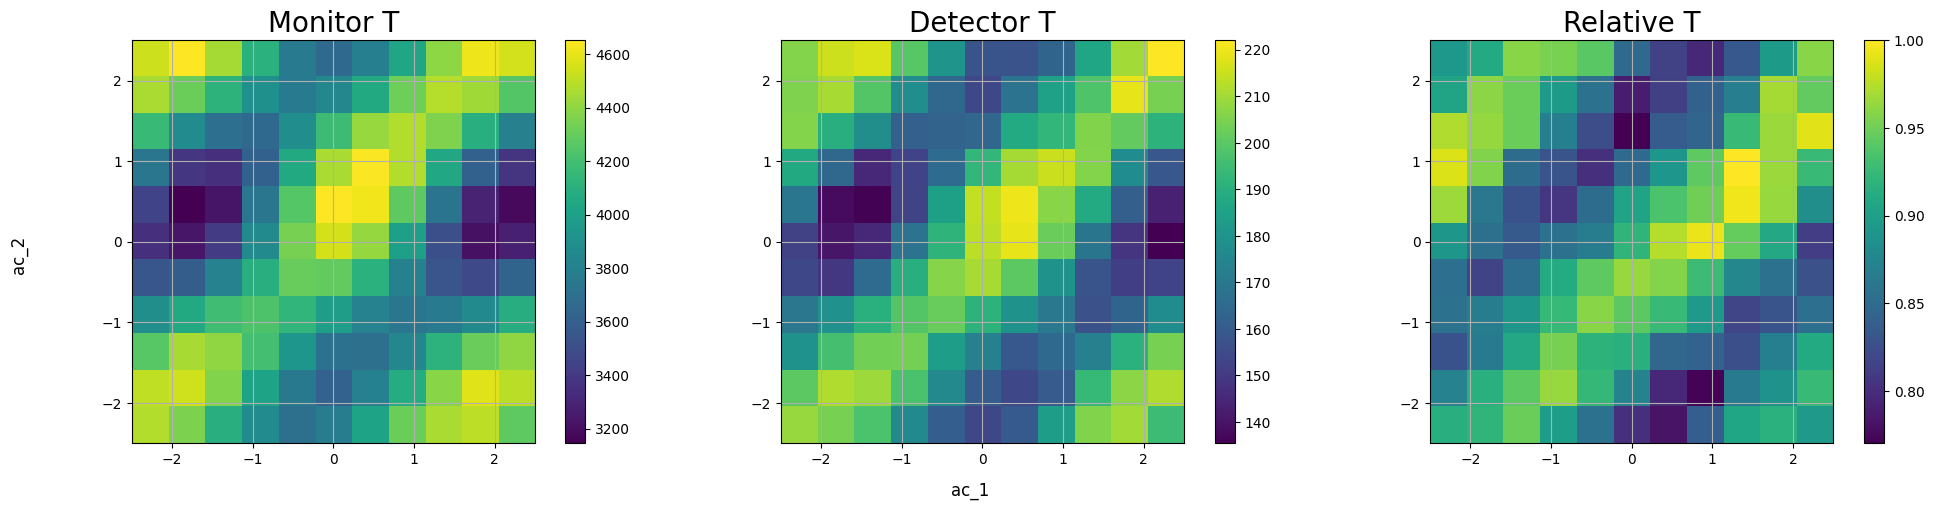

In [8]:
p1_in = data[11:22:,:,2]
p1_out = data[:11:,:,1]

_ = get_tr(p1_in,p1_out)

### MWP 3 amps:

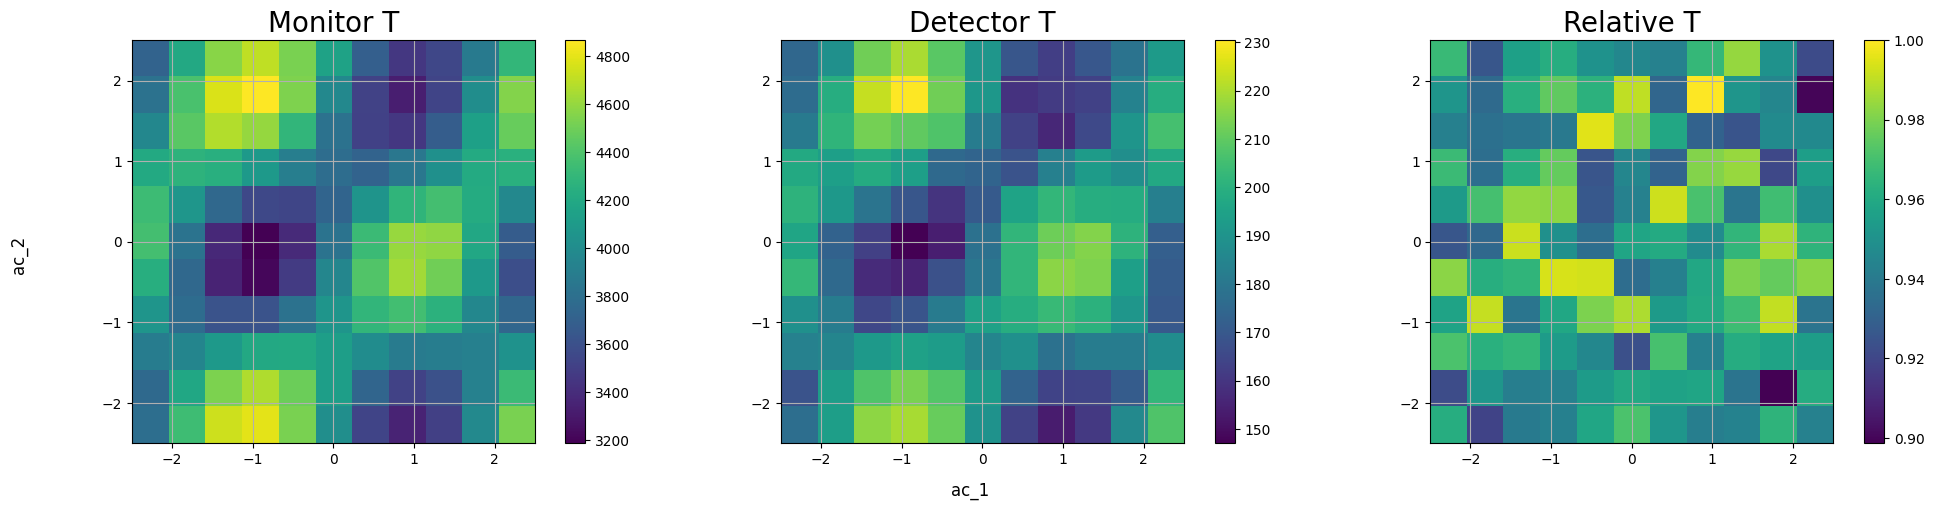

In [9]:
p3_in = data[33:44:,:,2]
p3_out = data[22:33:,:,1]

_ = get_tr(p3_in,p3_out)

### MWP 5 amps:

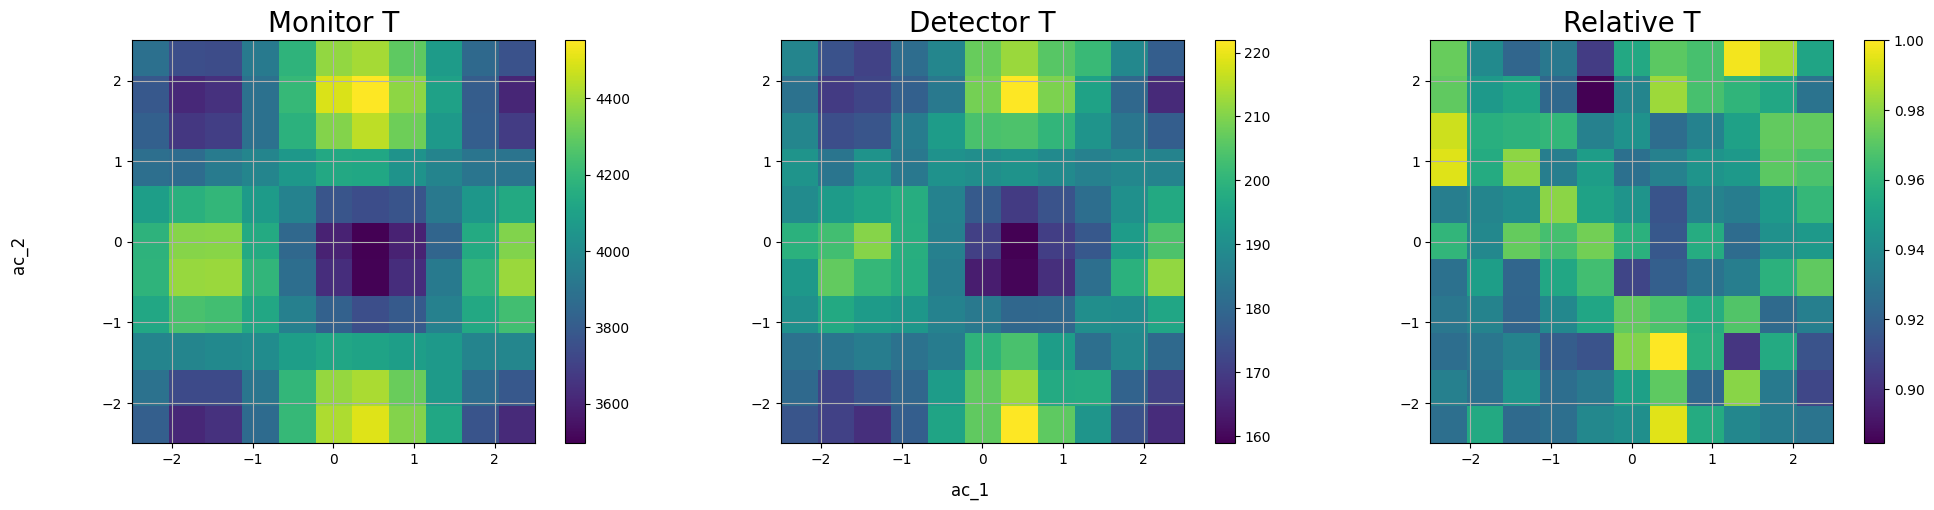

In [10]:
p5_in = data[55:66:,:,2]
p5_out = data[44:55:,:,1]

_ = get_tr(p5_in,p5_out)

### MWP 7 amps

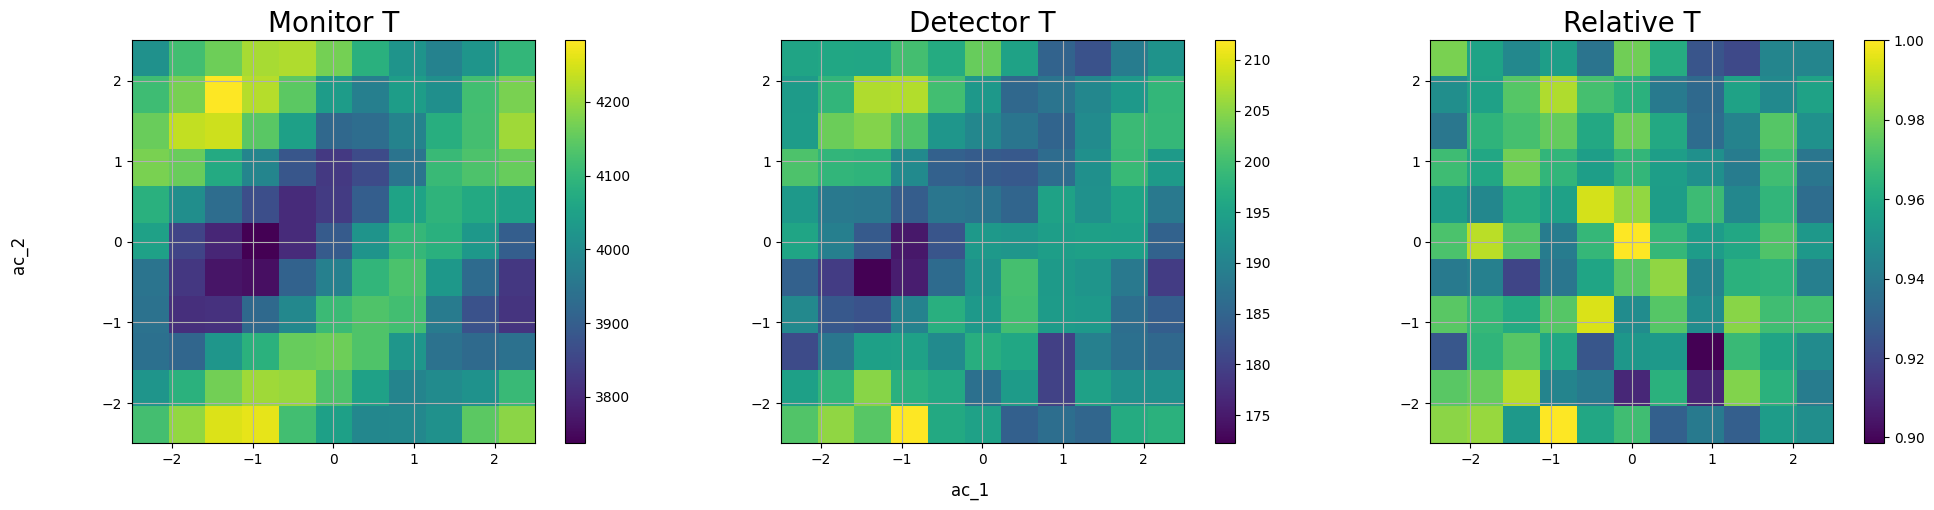

In [11]:
p7_in = data[77:88:,:,2]
p7_out = data[66:77:,:,1]

_ = get_tr(p7_in,p7_out)

### MWP 9 amps

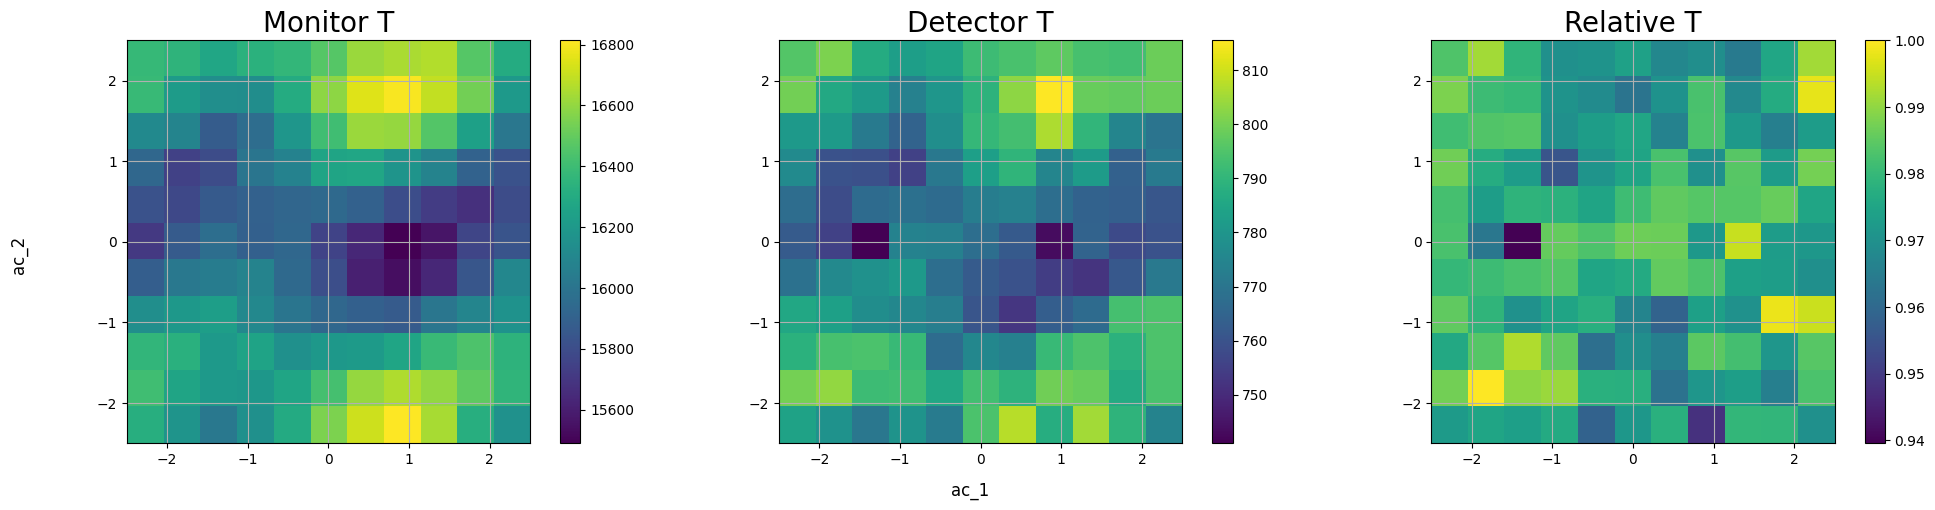

In [56]:
p9_in = np.sum([data[99+22*i:110+22*i:,:,2] for i in range(4)],axis=0)
p9_out = np.sum([data[88+22*i:99+22*i:,:,1] for i in range(4)],axis=0)
_ = get_tr(p9_in,p9_out)

### MWP 10 amps:

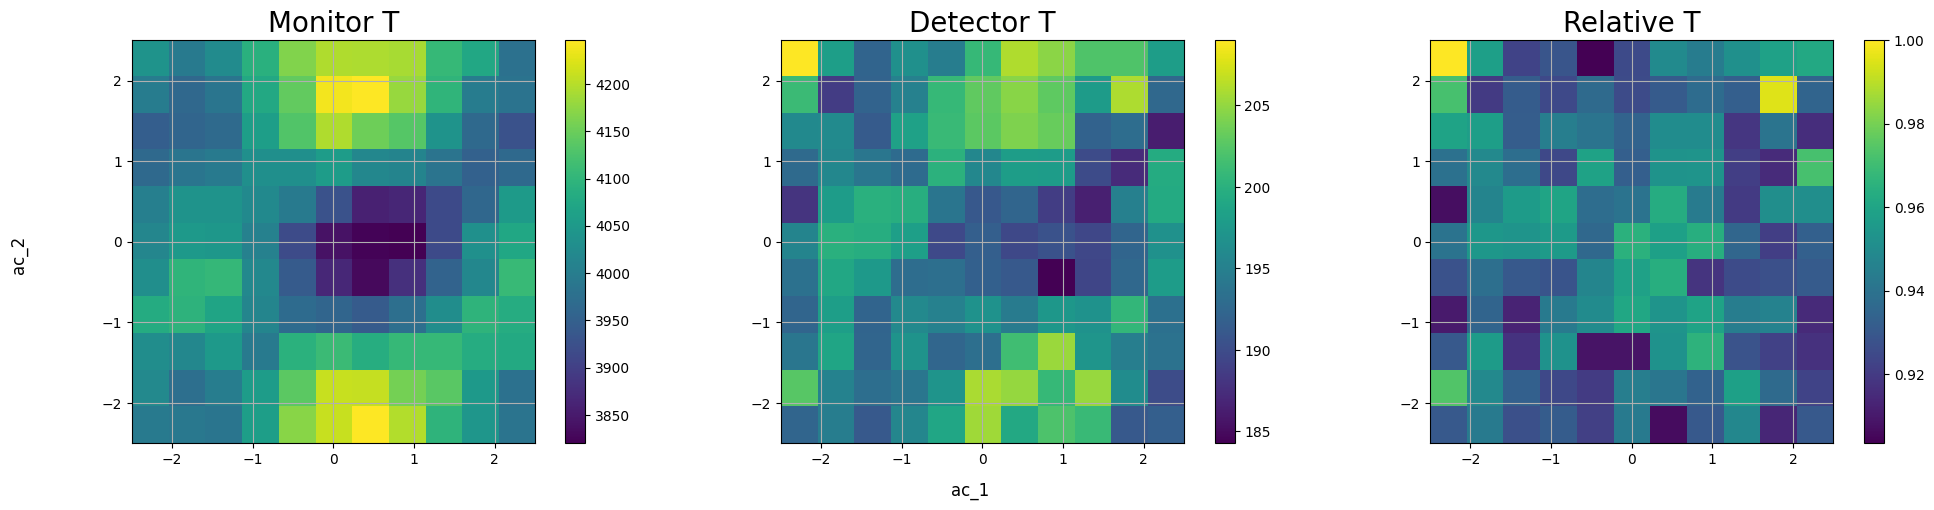

In [71]:
p10_in = data[176:187:,:,2]
p10_out = data[187:198:,:,1]
_ = get_tr(p10_in,p10_out)

In [ ]:
print(nums[198])

402


### MWP 12 amps:

ValueError: operands could not be broadcast together with shapes (4,11) (11,11) 

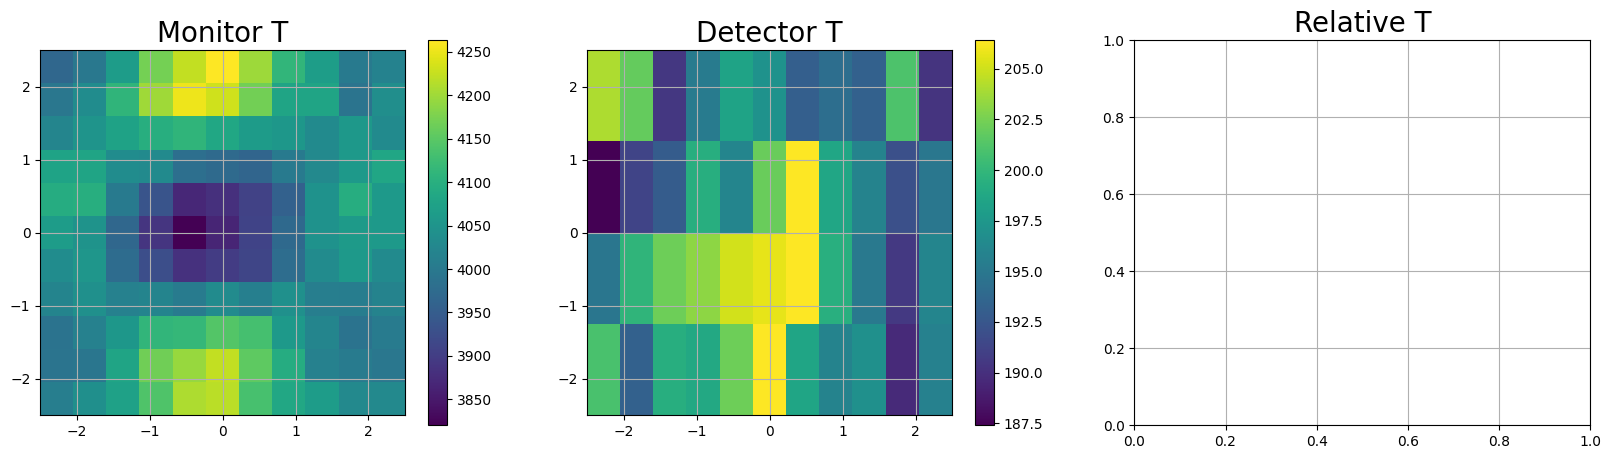

In [ ]:
p12_in = data[198:209:,:,2]
p12_out = data[209:198:,:,1]
_ = get_tr(p12_in,p12_out)

### 7/20: Rotated nutator_2:

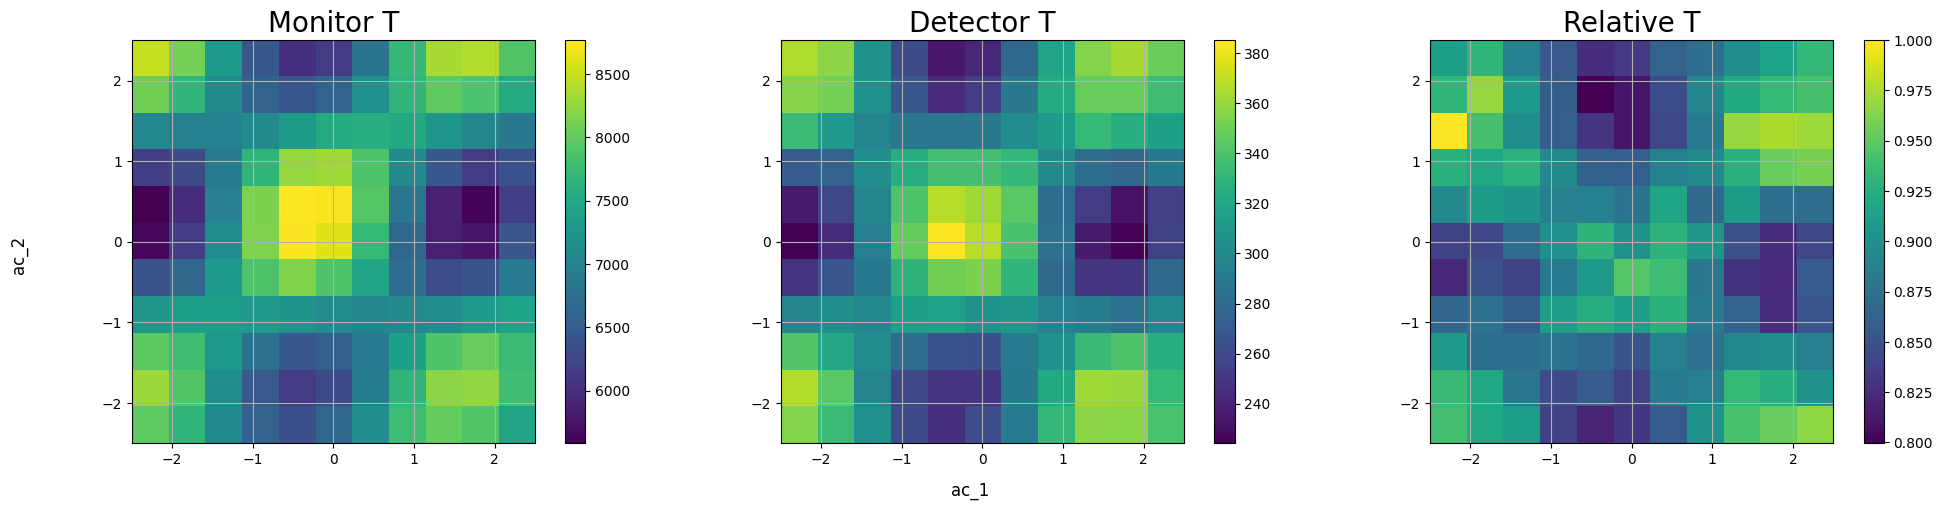

In [88]:
test_in = data[231:242:,:,2] 
test_out = data[220:231:,:,1]
_ = get_tr(test_in,test_out)

### 7/20 Overnight scan
***

Went from a 25 by 25 mm slit to a 14 by 10 mm slit, rotated nu_2 by 90 degrees, and extended the accelerator coils to a 2 rotation range.

In [189]:
file_range = range(446,572)
file_list = ["/HB2D_exp0005_scan" + get_scan(i) + ".dat" for i in file_range]

nums,*_,parms,data = load_data(data_path,file_list,dest_path,write_data=True,overwrite=True,reorder=True)

#### MWP 1 amp

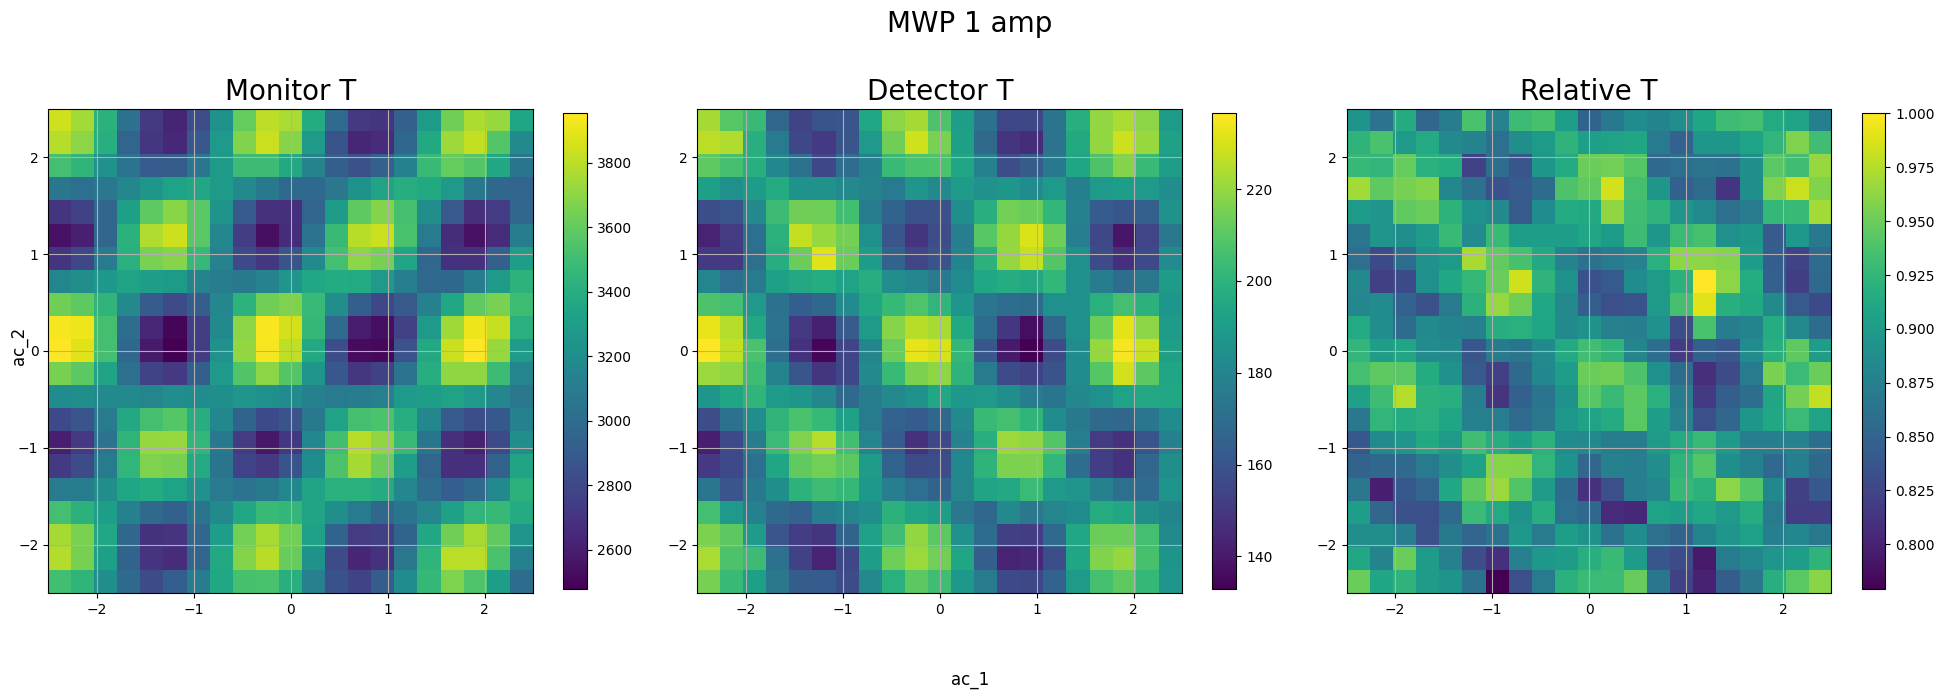

['446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472', '473', '474', '475', '476', '477', '478', '479', '480', '481', '482', '483', '484', '485', '486', '487']


In [186]:
start = 0
p1_out = data[start+21:start+42:,:,1]
p1_in = data[start:start+21:,:,2]
_ = get_tr(p1_in,p1_out,title='MWP 1 amp')
print(nums[start:start+42])

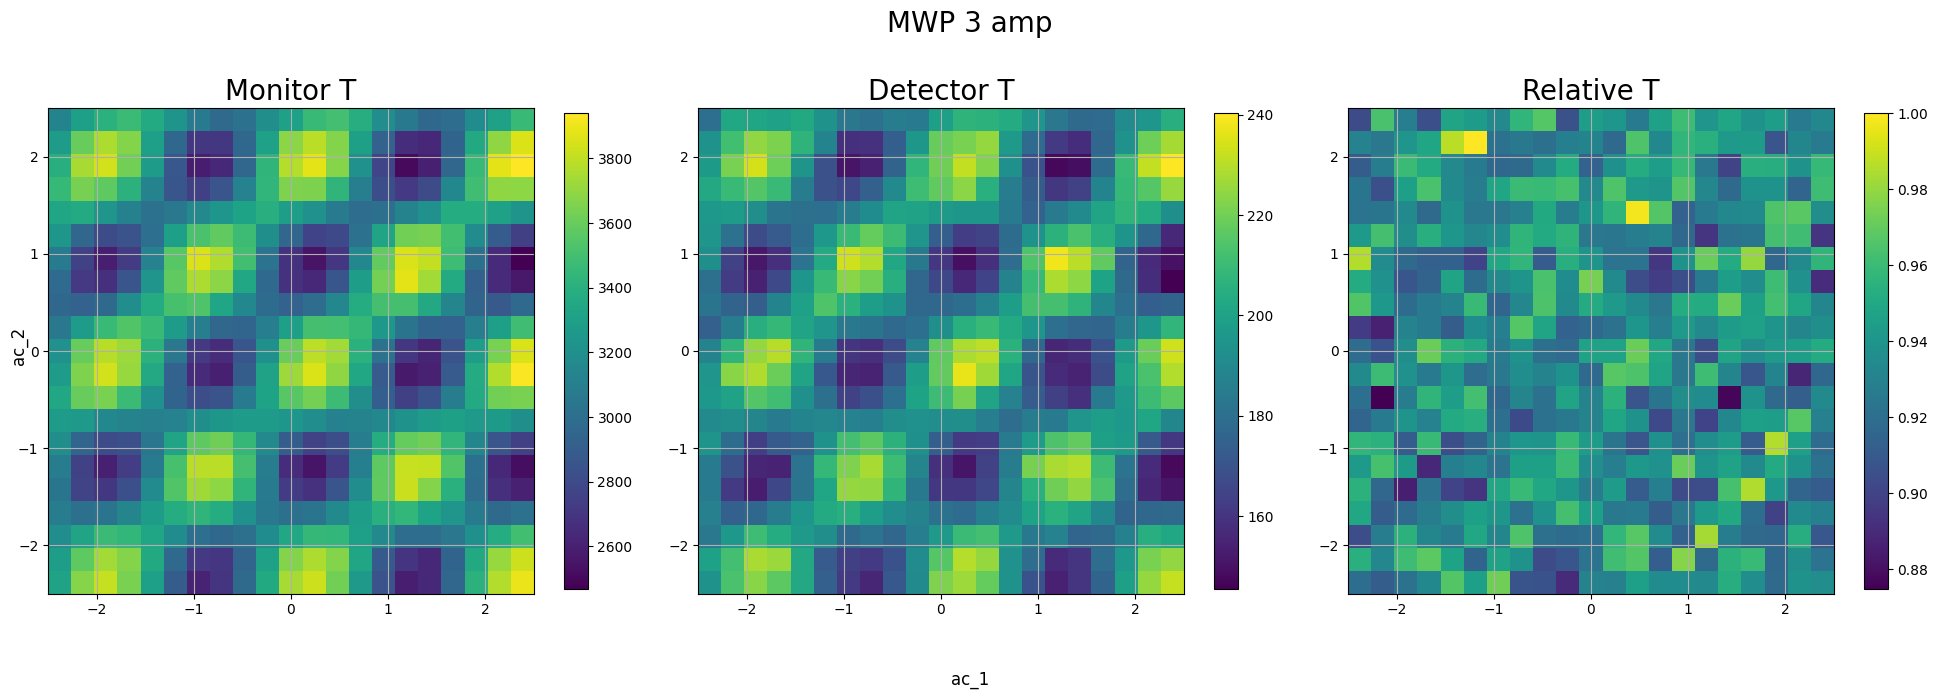

['488', '489', '490', '491', '492', '493', '494', '495', '496', '497', '498', '499', '500', '501', '502', '503', '504', '505', '506', '507', '508', '509', '510', '511', '512', '513', '514', '515', '516', '517', '518', '519', '520', '521', '522', '523', '524', '525', '526', '527', '528', '529']


In [187]:
start = 42
p3_out = data[start+21:start+42:,:,1]
p3_in = data[start:start+21:,:,2]
_ = get_tr(p3_in,p3_out,title='MWP 3 amp')
print(nums[start:start+42])

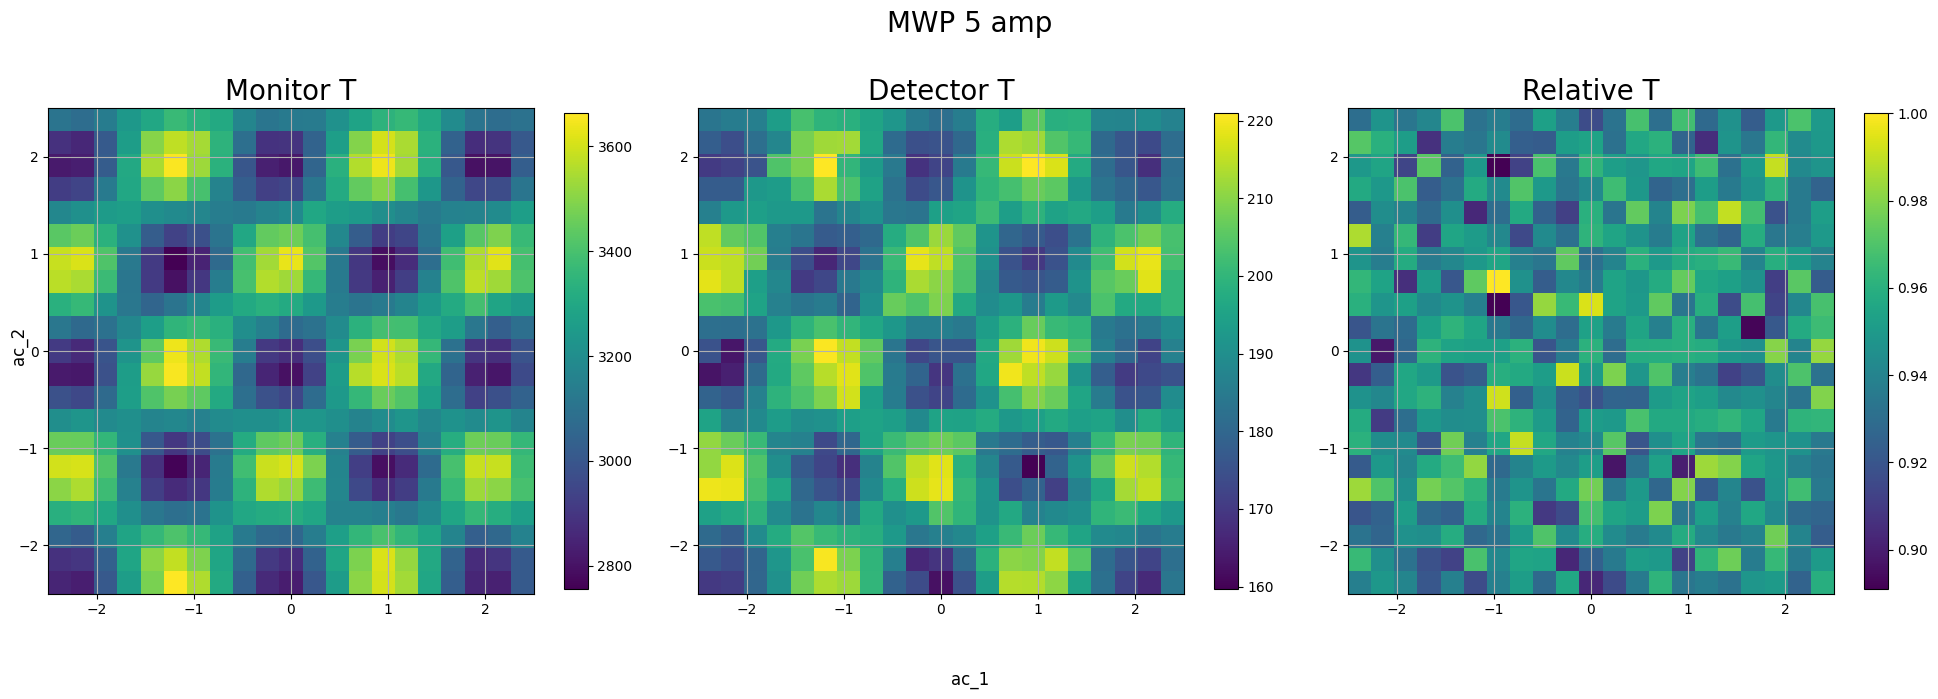

['530', '531', '532', '533', '534', '535', '536', '537', '538', '539', '540', '541', '542', '543', '544', '545', '546', '547', '548', '549', '550', '551', '552', '553', '554', '555', '556', '557', '558', '559', '560', '561', '562', '563', '564', '565', '566', '567', '568', '569', '570', '571']


In [192]:
start = 84
p3_out = data[start+21:start+42:,:,1]
p3_in = data[start:start+21:,:,2]
_ = get_tr(p3_in,p3_out,title='MWP 5 amp')
print(nums[start:start+42])

### 7/22 Mega test with offset currents

In [195]:
file_range = range(911,995)
file_list = ["/HB2D_exp0005_scan" + get_scan(i) + ".dat" for i in file_range]

nums,*_,parms,data = load_data(data_path,file_list,dest_path,write_data=True,overwrite=True,reorder=True)

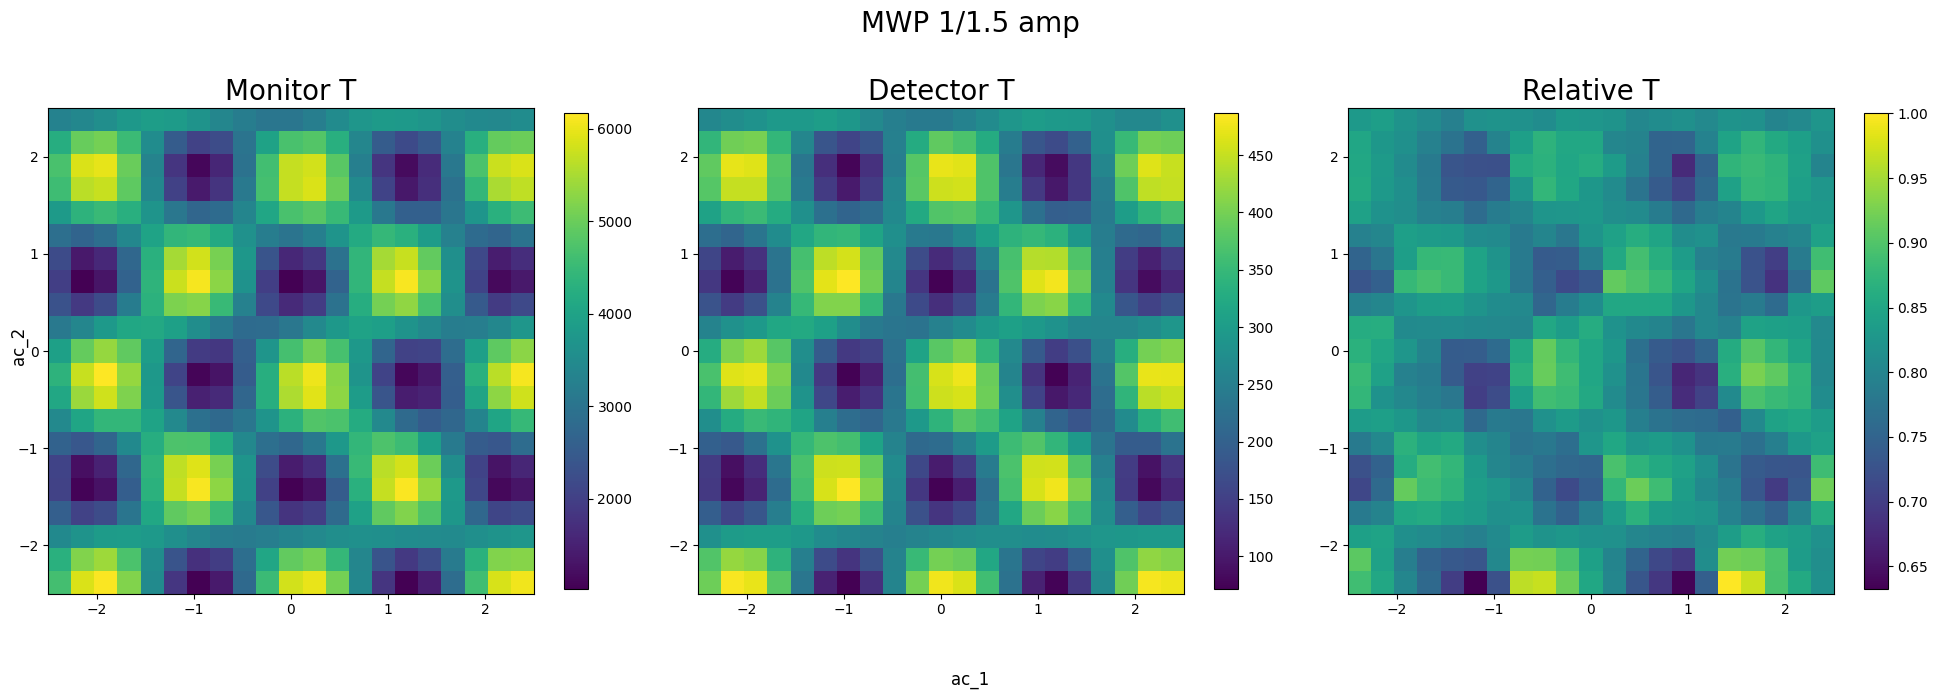

['911', '912', '913', '914', '915', '916', '917', '918', '919', '920', '921', '922', '923', '924', '925', '926', '927', '928', '929', '930', '931', '932', '933', '934', '935', '936', '937', '938', '939', '940', '941', '942', '943', '944', '945', '946', '947', '948', '949', '950', '951', '952']


In [201]:
start = 0
p_out = data[start+21:start+42:,:,1]
p_in = data[start:start+21:,:,2]
_ = get_tr(p_in,p_out,title='MWP 1/1.5 amp')
print(nums[start:start+42])

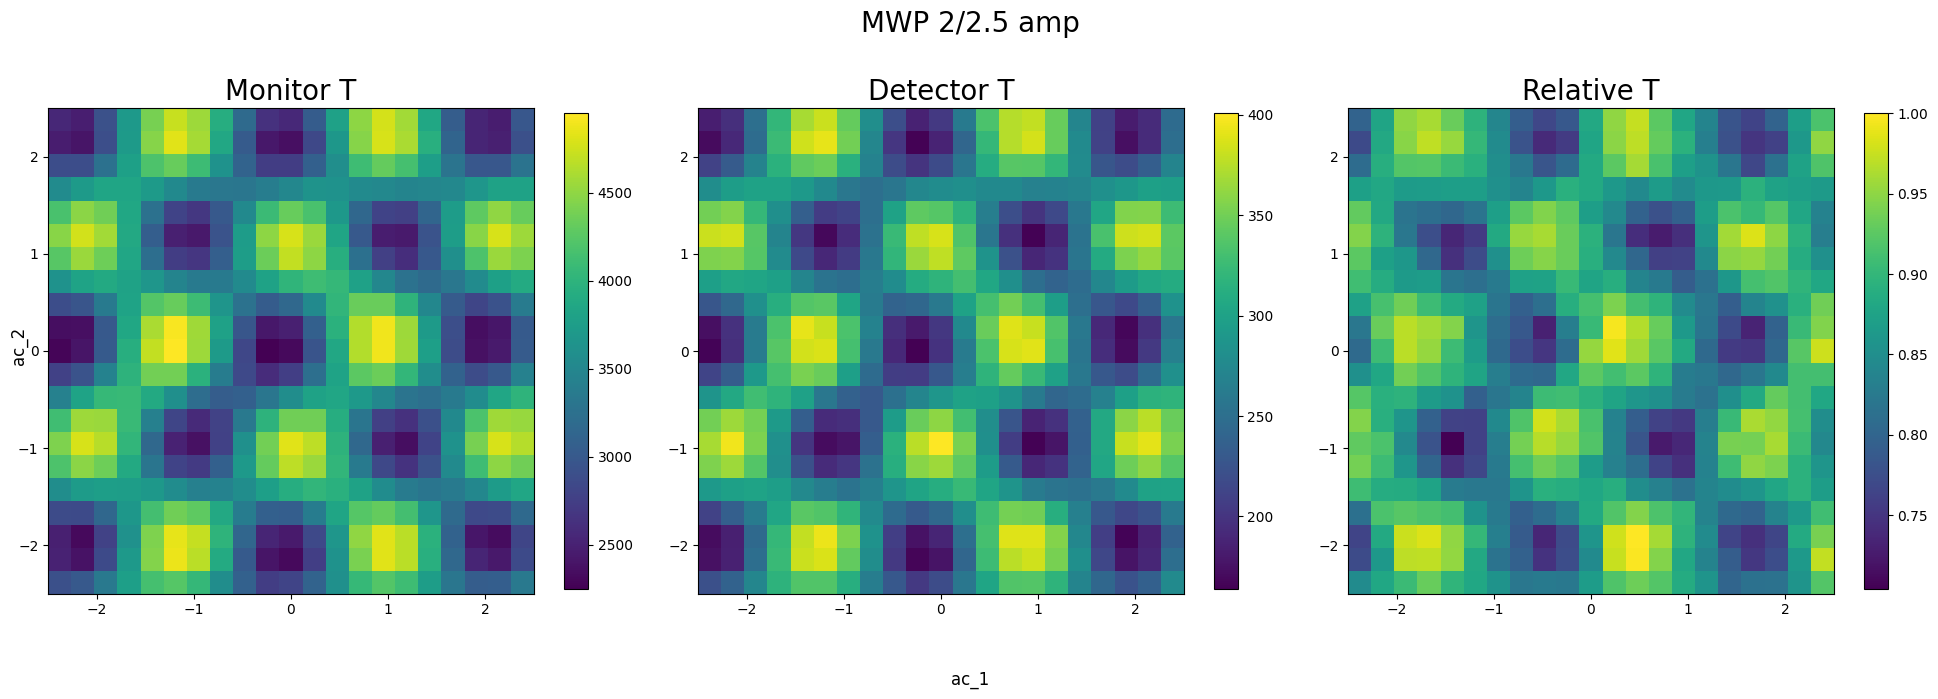

['953', '954', '955', '956', '957', '958', '959', '960', '961', '962', '963', '964', '965', '966', '967', '968', '969', '970', '971', '972', '973', '974', '975', '976', '977', '978', '979', '980', '981', '982', '983', '984', '985', '986', '987', '988', '989', '990', '991', '992', '993', '994']


In [202]:
start = 42
p_out = data[start+21:start+42:,:,1]
p_in = data[start:start+21:,:,2]
_ = get_tr(p_in,p_out,title='MWP 2/2.5 amp')
print(nums[start:start+42])

### 7/23 Mega test 2 after warming up

In [7]:
file_range = range(1025,1107)
file_list = ["/HB2D_exp0005_scan" + get_scan(i) + ".dat" for i in file_range]

nums,*_,parms,data = load_data(data_path,file_list,dest_path,write_data=True,overwrite=True,reorder=True)

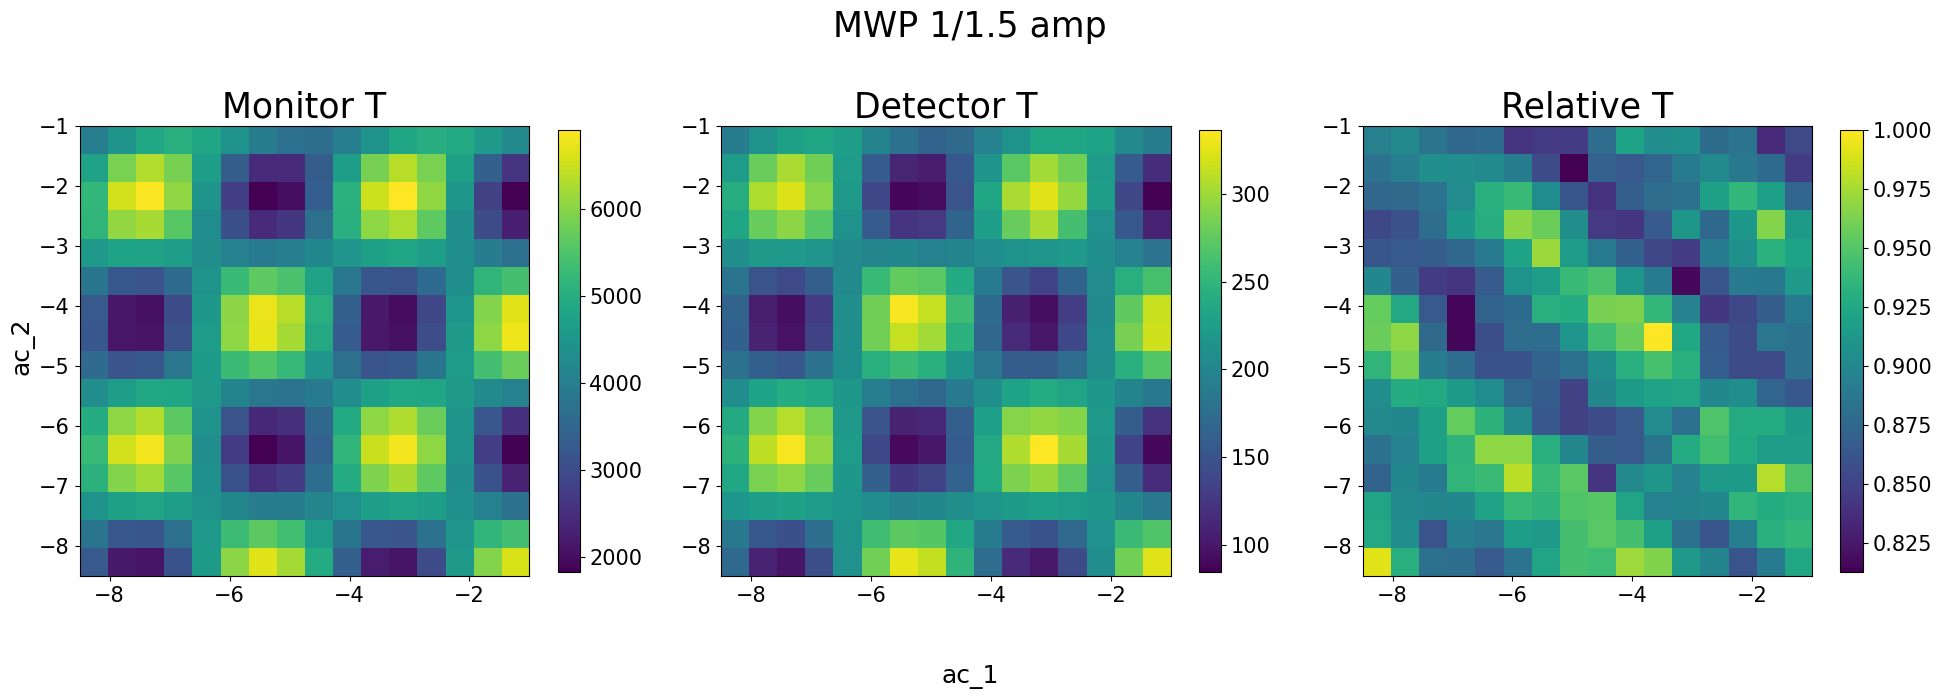

['1025', '1026', '1027', '1028', '1029', '1030', '1031', '1032', '1033', '1034', '1035', '1036', '1037', '1038', '1039', '1040', '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048', '1049', '1050', '1051', '1052', '1053', '1054', '1055', '1056']


In [14]:
start = 0
p_out = data[start+16:start+32:,:,1]
p_in = data[start:start+16:,:,2]
_ = get_tr(p_in,p_out,title='MWP 1/1.5 amp',ac_range=[-8.5,-1,-8.5,-1])
print(nums[start:start+32])

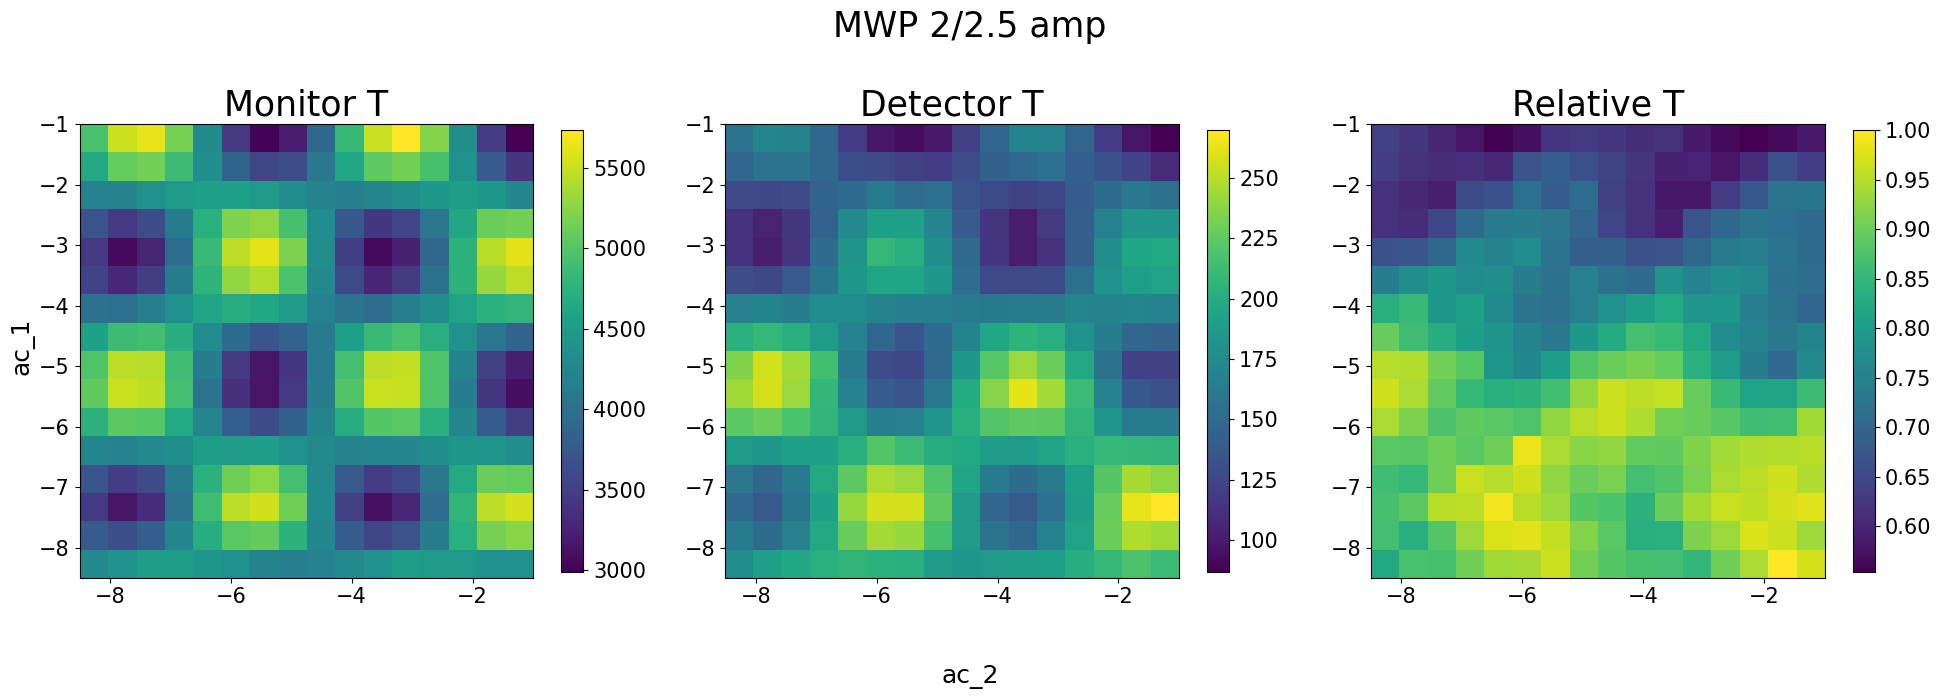

['1057', '1058', '1059', '1060', '1061', '1062', '1063', '1064', '1065', '1066', '1067', '1068', '1069', '1070', '1071', '1072', '1073', '1074', '1075', '1076', '1077', '1078', '1079', '1080', '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088']


In [17]:
start = 32
p_out = data[start+16:start+32:,:,1]
p_in = data[start:start+16:,:,2]
_ = get_tr(p_in,p_out,title='MWP 2/2.5 amp',ac_range=[-8.5,-1,-8.5,-1])
print(nums[start:start+32])

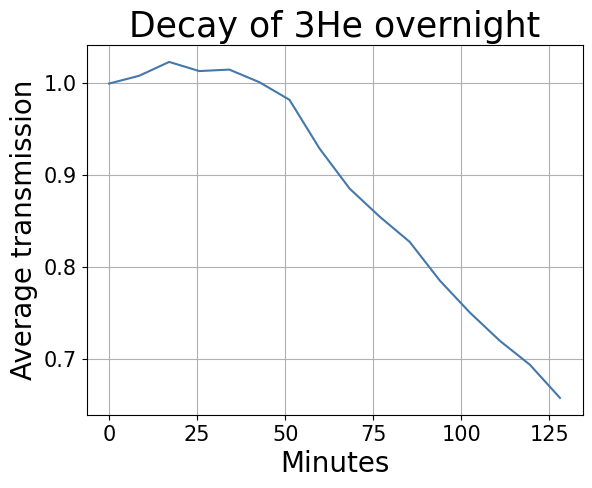

In [30]:
plt.plot(np.linspace(0,16*8,16),np.mean(_,axis=1)/.045)
plt.title('Decay of 3He overnight')
plt.ylabel('Average transmission')
plt.xlabel('Minutes')
plt.grid()
plt.show()

### 7/28 New setup scans

1. We put more slits in the beam (1 cm square) on each prism and before the monitor
2. Replaced s-bender analyzer with a second v-cavity
3. 

In [44]:
file_range = range(1461,1577)
file_list = ["/HB2D_exp0005_scan" + get_scan(i) + ".dat" for i in file_range]

nums,*_,parms,data = load_data(data_path,file_list,dest_path,write_data=True,overwrite=True,reorder=True)

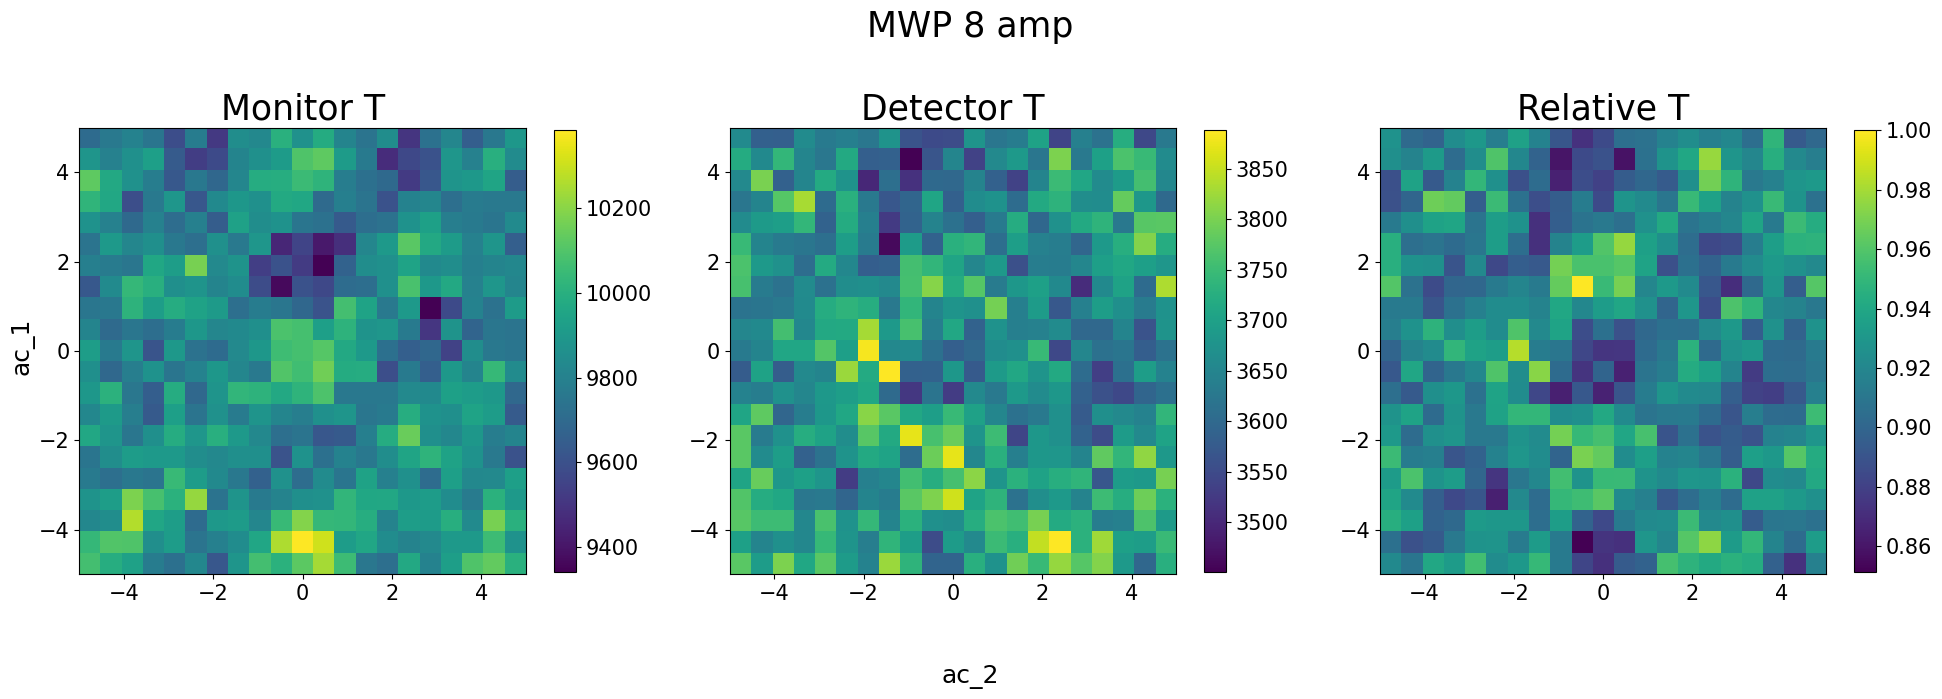

Monitor: ['1461', '1462', '1463', '1464', '1465', '1466', '1467', '1468', '1469', '1470', '1471', '1472', '1473', '1474', '1475', '1476', '1477', '1478', '1479', '1480', '1481']
Detector: ['1482', '1483', '1484', '1485', '1486', '1487', '1488', '1489', '1490', '1491', '1492', '1493', '1494', '1495', '1496', '1497', '1498', '1499', '1500', '1501', '1502']


In [48]:
start = 0
mon = data[start:start+21:,:,-2]
det = data[start+21:start+42:,:,-3]
_ = get_tr(mon,det,title='MWP 8 amp',ac_range=[-5,5,-5,5])
print(f'Monitor: {nums[start:start+21]}')
print(f'Detector: {nums[start+21:start+42]}')

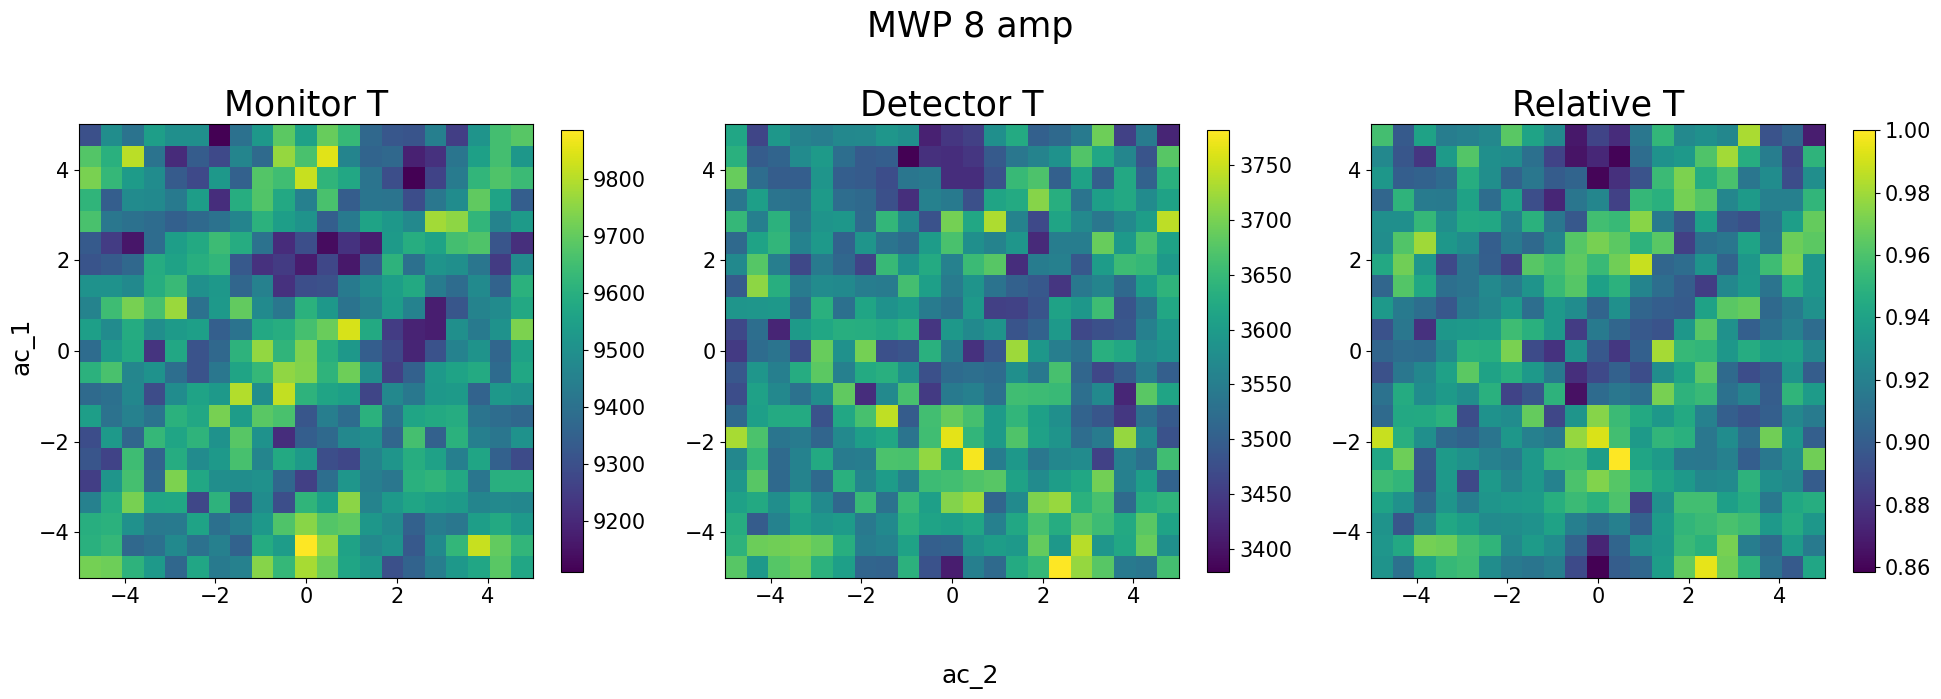

Monitor: ['1503', '1504', '1505', '1506', '1507', '1508', '1509', '1510', '1511', '1512', '1513', '1514', '1515', '1516', '1517', '1518', '1519', '1520', '1521', '1522', '1523']
Detector: ['1524', '1525', '1526', '1527', '1528', '1529', '1530', '1531', '1532', '1533', '1534', '1535', '1536', '1537', '1538', '1539', '1540', '1541', '1542', '1543', '1544']


In [49]:
start = 42
mon = data[start:start+21:,:,-2]
det = data[start+21:start+42:,:,-3]
_ = get_tr(mon,det,title='MWP 8 amp',ac_range=[-5,5,-5,5])
print(f'Monitor: {nums[start:start+21]}')
print(f'Detector: {nums[start+21:start+42]}')

Combined data set:

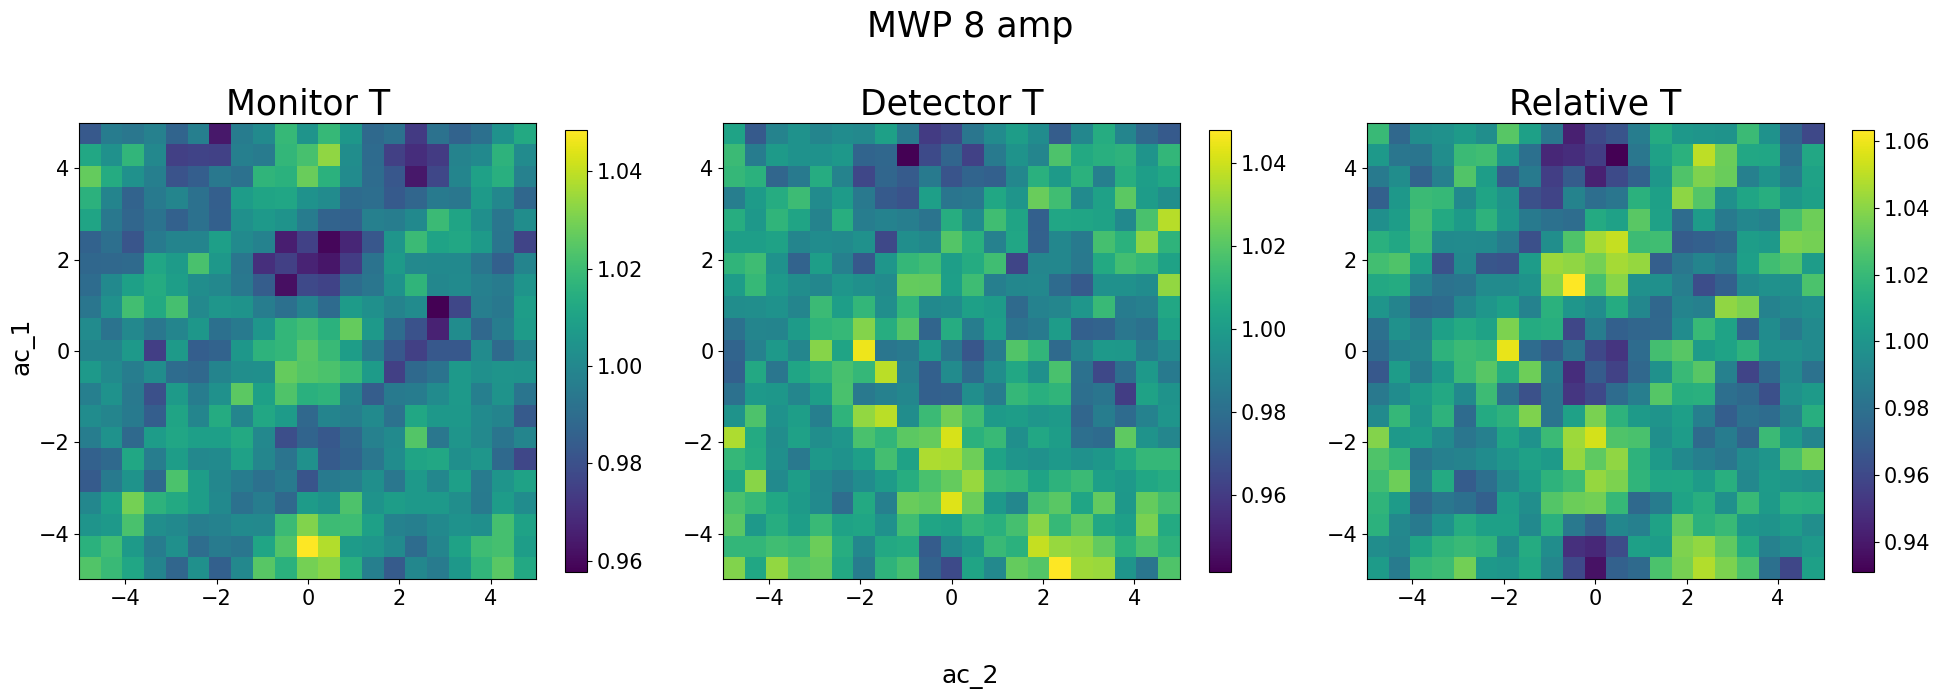

Monitor: (['1461', '1462', '1463', '1464', '1465', '1466', '1467', '1468', '1469', '1470', '1471', '1472', '1473', '1474', '1475', '1476', '1477', '1478', '1479', '1480', '1481'], ['1503', '1504', '1505', '1506', '1507', '1508', '1509', '1510', '1511', '1512', '1513', '1514', '1515', '1516', '1517', '1518', '1519', '1520', '1521', '1522', '1523'])
Detector: (['1482', '1483', '1484', '1485', '1486', '1487', '1488', '1489', '1490', '1491', '1492', '1493', '1494', '1495', '1496', '1497', '1498', '1499', '1500', '1501', '1502'], ['1503', '1504', '1505', '1506', '1507', '1508', '1509', '1510', '1511', '1512', '1513', '1514', '1515', '1516', '1517', '1518', '1519', '1520', '1521', '1522', '1523'])


In [60]:
start = 0
mon = data[start:start+21:,:,-2] + data[42:42+21:,:,-2]
det = data[start+21:start+42:,:,-3] + data[42+21:42+42:,:,-3]
_ = get_tr(mon,det,title='MWP 8 amp',ac_range=[-5,5,-5,5],contrast=True)
print(f'Monitor: {nums[start:start+21],nums[42:42+21]}')
print(f'Detector: {nums[start+21:start+42],nums[42:42+21]}')

### 7/29 Continuing the 8 amp MWP scan

In [39]:
file_range = range(1577,1629) #monitor didn't drive out of the beam for the overnight scans
file_list = ["/HB2D_exp0005_scan" + get_scan(i) + ".dat" for i in file_range]

nums,*_,parms,data = load_data(data_path,file_list,dest_path,write_data=True,overwrite=True,reorder=True)

In [41]:
file_range = range(1629,1633) #monitor didn't drive out of the beam for the overnight scans
file_list = ["/HB2D_exp0005_scan" + get_scan(i) + ".dat" for i in file_range]

nums,*_,parms,data = load_data(data_path,file_list,dest_path,write_data=True,overwrite=True,reorder=True)

In [28]:
start = 1634
for i in range(5):
    file_range = range(start+10*i,start+10*(i+1))
    file_list = ["/HB2D_exp0005_scan" + get_scan(i) + ".dat" for i in file_range]
    _ = load_data(data_path,file_list,dest_path,write_data=True,overwrite=True,reorder=True)

In [37]:
start = 1686
for i in range(4):
    file_range = range(start+14*i,start+14*(i+1))
    file_list = ["/HB2D_exp0005_scan" + get_scan(i) + ".dat" for i in file_range]
    _ = load_data(data_path,file_list,dest_path,write_data=True,overwrite=True,reorder=True)

In [ ]:
start = 1746
for i in range(4):
    file_range = range(start+14*i,start+14*(i+1))
    file_list = ["/HB2D_exp0005_scan" + get_scan(i) + ".dat" for i in file_range]
    _ = load_data(data_path,file_list,dest_path,write_data=True,overwrite=True,reorder=True)

### 7/31 Still analyzing the long scan data

In [55]:
for i in range (1847,1904):
    file_range = [i]
    file_list = ["/HB2D_exp0005_scan" + get_scan(i) + ".dat" for i in file_range]

    nums,*_,parms,data = load_data(data_path,file_list,dest_path,write_data=True,overwrite=True,reorder=True)